In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_256/models/epoch_45.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_256/data/test_data_protocol_4.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_256/models/epoch_45.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(2, 30))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

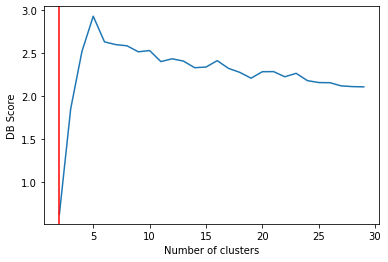

{0, 1}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

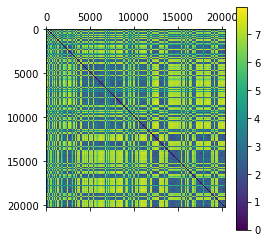

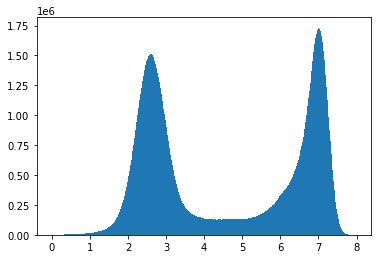

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

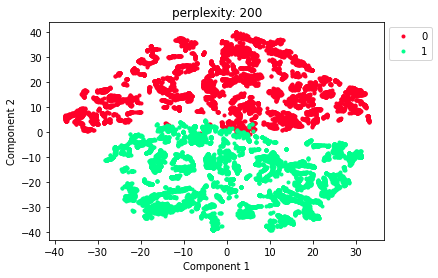

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 8

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9770856945744838


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.3839454013649659
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.7417127071823204
layer 3: 0.7417127071823204
layer 4: 0.6799033149171271
layer 5: 0.5253798342541436
layer 6: 0.41721339779005523
Epoch: 00 | Batch: 000 / 011 | Total loss: 0.698 | Reg loss: 0.015 | Tree loss: 0.698 | Accuracy: 0.504500 | 1.089 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 0.698 | Reg loss: 0.015 | Tree loss: 0.698 | Accuracy: 0.519500 | 0.656 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 0.698 | Reg loss: 0.014 | Tree loss: 0.698 | Accuracy: 0.490000 | 0.511 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 0.691 | Reg loss: 0.014 | Tree loss: 0.691 | Accuracy: 0.539000 | 0.447 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 0.693 | Reg loss: 0.014 | Tree loss: 0.693 | Accuracy: 0.540000 | 0.41 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 0.690 | Reg loss: 0.014 | Tree loss: 0.690 | Accuracy: 0.564500 | 0.388 sec/iter
Epoch: 00 | Batch: 006 

layer 6: 0.9723756906077349
Epoch: 05 | Batch: 000 / 011 | Total loss: 0.688 | Reg loss: 0.012 | Tree loss: 0.688 | Accuracy: 0.653500 | 0.694 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 0.686 | Reg loss: 0.012 | Tree loss: 0.686 | Accuracy: 0.681000 | 0.687 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 0.684 | Reg loss: 0.012 | Tree loss: 0.684 | Accuracy: 0.721500 | 0.68 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 0.684 | Reg loss: 0.012 | Tree loss: 0.684 | Accuracy: 0.676000 | 0.673 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 0.681 | Reg loss: 0.012 | Tree loss: 0.681 | Accuracy: 0.628000 | 0.667 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 0.676 | Reg loss: 0.012 | Tree loss: 0.676 | Accuracy: 0.618500 | 0.66 sec/iter
Epoch: 05 | Batch: 006 / 011 | Total loss: 0.679 | Reg loss: 0.012 | Tree loss: 0.679 | Accuracy: 0.587500 | 0.654 sec/iter
Epoch: 05 | Batch: 007 / 011 | Total loss: 0.681 | Reg loss: 0.012 | Tree loss: 0.681 | Accuracy: 0.574500

Epoch: 10 | Batch: 002 / 011 | Total loss: 0.669 | Reg loss: 0.012 | Tree loss: 0.669 | Accuracy: 0.723500 | 0.636 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 0.669 | Reg loss: 0.012 | Tree loss: 0.669 | Accuracy: 0.716000 | 0.633 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 0.663 | Reg loss: 0.012 | Tree loss: 0.663 | Accuracy: 0.699000 | 0.63 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 0.656 | Reg loss: 0.012 | Tree loss: 0.656 | Accuracy: 0.667000 | 0.627 sec/iter
Epoch: 10 | Batch: 006 / 011 | Total loss: 0.667 | Reg loss: 0.012 | Tree loss: 0.667 | Accuracy: 0.592000 | 0.624 sec/iter
Epoch: 10 | Batch: 007 / 011 | Total loss: 0.655 | Reg loss: 0.013 | Tree loss: 0.655 | Accuracy: 0.604500 | 0.622 sec/iter
Epoch: 10 | Batch: 008 / 011 | Total loss: 0.654 | Reg loss: 0.013 | Tree loss: 0.654 | Accuracy: 0.614000 | 0.619 sec/iter
Epoch: 10 | Batch: 009 / 011 | Total loss: 0.657 | Reg loss: 0.013 | Tree loss: 0.657 | Accuracy: 0.589000 | 0.616 sec/iter
Epoch: 10

Epoch: 15 | Batch: 004 / 011 | Total loss: 0.633 | Reg loss: 0.013 | Tree loss: 0.633 | Accuracy: 0.695000 | 0.604 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 0.629 | Reg loss: 0.013 | Tree loss: 0.629 | Accuracy: 0.672500 | 0.602 sec/iter
Epoch: 15 | Batch: 006 / 011 | Total loss: 0.620 | Reg loss: 0.013 | Tree loss: 0.620 | Accuracy: 0.672500 | 0.6 sec/iter
Epoch: 15 | Batch: 007 / 011 | Total loss: 0.620 | Reg loss: 0.013 | Tree loss: 0.620 | Accuracy: 0.681000 | 0.598 sec/iter
Epoch: 15 | Batch: 008 / 011 | Total loss: 0.608 | Reg loss: 0.014 | Tree loss: 0.608 | Accuracy: 0.710000 | 0.596 sec/iter
Epoch: 15 | Batch: 009 / 011 | Total loss: 0.607 | Reg loss: 0.014 | Tree loss: 0.607 | Accuracy: 0.731500 | 0.594 sec/iter
Epoch: 15 | Batch: 010 / 011 | Total loss: 0.597 | Reg loss: 0.014 | Tree loss: 0.597 | Accuracy: 0.778157 | 0.592 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.

Epoch: 20 | Batch: 006 / 011 | Total loss: 0.573 | Reg loss: 0.014 | Tree loss: 0.573 | Accuracy: 0.736500 | 0.612 sec/iter
Epoch: 20 | Batch: 007 / 011 | Total loss: 0.560 | Reg loss: 0.014 | Tree loss: 0.560 | Accuracy: 0.815000 | 0.611 sec/iter
Epoch: 20 | Batch: 008 / 011 | Total loss: 0.573 | Reg loss: 0.014 | Tree loss: 0.573 | Accuracy: 0.809500 | 0.609 sec/iter
Epoch: 20 | Batch: 009 / 011 | Total loss: 0.559 | Reg loss: 0.014 | Tree loss: 0.559 | Accuracy: 0.813000 | 0.608 sec/iter
Epoch: 20 | Batch: 010 / 011 | Total loss: 0.553 | Reg loss: 0.014 | Tree loss: 0.553 | Accuracy: 0.798635 | 0.606 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 21 | Batch: 000 / 011 | Total loss: 0.618 | Reg loss: 0.014 | Tree loss: 0.618 | Accuracy: 0.713000 | 0.629 sec/iter
Epoch: 21 | Batch: 00

Epoch: 25 | Batch: 008 / 011 | Total loss: 0.536 | Reg loss: 0.014 | Tree loss: 0.536 | Accuracy: 0.797500 | 0.636 sec/iter
Epoch: 25 | Batch: 009 / 011 | Total loss: 0.542 | Reg loss: 0.014 | Tree loss: 0.542 | Accuracy: 0.789000 | 0.635 sec/iter
Epoch: 25 | Batch: 010 / 011 | Total loss: 0.527 | Reg loss: 0.014 | Tree loss: 0.527 | Accuracy: 0.808874 | 0.633 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 26 | Batch: 000 / 011 | Total loss: 0.613 | Reg loss: 0.014 | Tree loss: 0.613 | Accuracy: 0.667000 | 0.649 sec/iter
Epoch: 26 | Batch: 001 / 011 | Total loss: 0.579 | Reg loss: 0.014 | Tree loss: 0.579 | Accuracy: 0.736500 | 0.647 sec/iter
Epoch: 26 | Batch: 002 / 011 | Total loss: 0.570 | Reg loss: 0.014 | Tree loss: 0.570 | Accuracy: 0.723000 | 0.646 sec/iter
Epoch: 26 | Batch: 00

Epoch: 30 | Batch: 010 / 011 | Total loss: 0.510 | Reg loss: 0.015 | Tree loss: 0.510 | Accuracy: 0.781570 | 0.618 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 31 | Batch: 000 / 011 | Total loss: 0.582 | Reg loss: 0.014 | Tree loss: 0.582 | Accuracy: 0.693500 | 0.631 sec/iter
Epoch: 31 | Batch: 001 / 011 | Total loss: 0.572 | Reg loss: 0.014 | Tree loss: 0.572 | Accuracy: 0.712500 | 0.63 sec/iter
Epoch: 31 | Batch: 002 / 011 | Total loss: 0.543 | Reg loss: 0.014 | Tree loss: 0.543 | Accuracy: 0.737000 | 0.629 sec/iter
Epoch: 31 | Batch: 003 / 011 | Total loss: 0.555 | Reg loss: 0.014 | Tree loss: 0.555 | Accuracy: 0.716000 | 0.628 sec/iter
Epoch: 31 | Batch: 004 / 011 | Total loss: 0.530 | Reg loss: 0.014 | Tree loss: 0.530 | Accuracy: 0.732000 | 0.626 sec/iter
Epoch: 31 | Batch: 005

Epoch: 36 | Batch: 000 / 011 | Total loss: 0.582 | Reg loss: 0.015 | Tree loss: 0.582 | Accuracy: 0.684000 | 0.606 sec/iter
Epoch: 36 | Batch: 001 / 011 | Total loss: 0.546 | Reg loss: 0.015 | Tree loss: 0.546 | Accuracy: 0.710000 | 0.605 sec/iter
Epoch: 36 | Batch: 002 / 011 | Total loss: 0.539 | Reg loss: 0.015 | Tree loss: 0.539 | Accuracy: 0.729000 | 0.604 sec/iter
Epoch: 36 | Batch: 003 / 011 | Total loss: 0.519 | Reg loss: 0.015 | Tree loss: 0.519 | Accuracy: 0.750000 | 0.603 sec/iter
Epoch: 36 | Batch: 004 / 011 | Total loss: 0.521 | Reg loss: 0.015 | Tree loss: 0.521 | Accuracy: 0.735500 | 0.603 sec/iter
Epoch: 36 | Batch: 005 / 011 | Total loss: 0.510 | Reg loss: 0.015 | Tree loss: 0.510 | Accuracy: 0.771000 | 0.602 sec/iter
Epoch: 36 | Batch: 006 / 011 | Total loss: 0.516 | Reg loss: 0.015 | Tree loss: 0.516 | Accuracy: 0.794000 | 0.601 sec/iter
Epoch: 36 | Batch: 007 / 011 | Total loss: 0.490 | Reg loss: 0.015 | Tree loss: 0.490 | Accuracy: 0.796500 | 0.6 sec/iter
Epoch: 36 

Epoch: 41 | Batch: 002 / 011 | Total loss: 0.518 | Reg loss: 0.015 | Tree loss: 0.518 | Accuracy: 0.722000 | 0.607 sec/iter
Epoch: 41 | Batch: 003 / 011 | Total loss: 0.503 | Reg loss: 0.015 | Tree loss: 0.503 | Accuracy: 0.744500 | 0.606 sec/iter
Epoch: 41 | Batch: 004 / 011 | Total loss: 0.510 | Reg loss: 0.015 | Tree loss: 0.510 | Accuracy: 0.753500 | 0.606 sec/iter
Epoch: 41 | Batch: 005 / 011 | Total loss: 0.502 | Reg loss: 0.015 | Tree loss: 0.502 | Accuracy: 0.787000 | 0.605 sec/iter
Epoch: 41 | Batch: 006 / 011 | Total loss: 0.493 | Reg loss: 0.015 | Tree loss: 0.493 | Accuracy: 0.793500 | 0.604 sec/iter
Epoch: 41 | Batch: 007 / 011 | Total loss: 0.475 | Reg loss: 0.015 | Tree loss: 0.475 | Accuracy: 0.803500 | 0.604 sec/iter
Epoch: 41 | Batch: 008 / 011 | Total loss: 0.480 | Reg loss: 0.015 | Tree loss: 0.480 | Accuracy: 0.846000 | 0.603 sec/iter
Epoch: 41 | Batch: 009 / 011 | Total loss: 0.484 | Reg loss: 0.015 | Tree loss: 0.484 | Accuracy: 0.809500 | 0.602 sec/iter
Epoch: 4

Epoch: 46 | Batch: 004 / 011 | Total loss: 0.504 | Reg loss: 0.016 | Tree loss: 0.504 | Accuracy: 0.756500 | 0.631 sec/iter
Epoch: 46 | Batch: 005 / 011 | Total loss: 0.502 | Reg loss: 0.016 | Tree loss: 0.502 | Accuracy: 0.772500 | 0.63 sec/iter
Epoch: 46 | Batch: 006 / 011 | Total loss: 0.494 | Reg loss: 0.016 | Tree loss: 0.494 | Accuracy: 0.799000 | 0.629 sec/iter
Epoch: 46 | Batch: 007 / 011 | Total loss: 0.472 | Reg loss: 0.016 | Tree loss: 0.472 | Accuracy: 0.809000 | 0.628 sec/iter
Epoch: 46 | Batch: 008 / 011 | Total loss: 0.468 | Reg loss: 0.016 | Tree loss: 0.468 | Accuracy: 0.833000 | 0.628 sec/iter
Epoch: 46 | Batch: 009 / 011 | Total loss: 0.458 | Reg loss: 0.016 | Tree loss: 0.458 | Accuracy: 0.831000 | 0.627 sec/iter
Epoch: 46 | Batch: 010 / 011 | Total loss: 0.498 | Reg loss: 0.016 | Tree loss: 0.498 | Accuracy: 0.767918 | 0.626 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0

Epoch: 51 | Batch: 006 / 011 | Total loss: 0.492 | Reg loss: 0.016 | Tree loss: 0.492 | Accuracy: 0.796500 | 0.627 sec/iter
Epoch: 51 | Batch: 007 / 011 | Total loss: 0.479 | Reg loss: 0.016 | Tree loss: 0.479 | Accuracy: 0.804000 | 0.626 sec/iter
Epoch: 51 | Batch: 008 / 011 | Total loss: 0.457 | Reg loss: 0.016 | Tree loss: 0.457 | Accuracy: 0.817000 | 0.626 sec/iter
Epoch: 51 | Batch: 009 / 011 | Total loss: 0.458 | Reg loss: 0.016 | Tree loss: 0.458 | Accuracy: 0.841000 | 0.625 sec/iter
Epoch: 51 | Batch: 010 / 011 | Total loss: 0.443 | Reg loss: 0.016 | Tree loss: 0.443 | Accuracy: 0.853242 | 0.624 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 52 | Batch: 000 / 011 | Total loss: 0.546 | Reg loss: 0.016 | Tree loss: 0.546 | Accuracy: 0.704500 | 0.626 sec/iter
Epoch: 52 | Batch: 00

Epoch: 56 | Batch: 008 / 011 | Total loss: 0.452 | Reg loss: 0.016 | Tree loss: 0.452 | Accuracy: 0.807500 | 0.606 sec/iter
Epoch: 56 | Batch: 009 / 011 | Total loss: 0.454 | Reg loss: 0.016 | Tree loss: 0.454 | Accuracy: 0.807000 | 0.605 sec/iter
Epoch: 56 | Batch: 010 / 011 | Total loss: 0.459 | Reg loss: 0.016 | Tree loss: 0.459 | Accuracy: 0.853242 | 0.604 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 57 | Batch: 000 / 011 | Total loss: 0.541 | Reg loss: 0.016 | Tree loss: 0.541 | Accuracy: 0.716000 | 0.605 sec/iter
Epoch: 57 | Batch: 001 / 011 | Total loss: 0.523 | Reg loss: 0.016 | Tree loss: 0.523 | Accuracy: 0.760500 | 0.604 sec/iter
Epoch: 57 | Batch: 002 / 011 | Total loss: 0.490 | Reg loss: 0.016 | Tree loss: 0.490 | Accuracy: 0.772000 | 0.603 sec/iter
Epoch: 57 | Batch: 00

Epoch: 61 | Batch: 010 / 011 | Total loss: 0.442 | Reg loss: 0.016 | Tree loss: 0.442 | Accuracy: 0.825939 | 0.598 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 62 | Batch: 000 / 011 | Total loss: 0.533 | Reg loss: 0.016 | Tree loss: 0.533 | Accuracy: 0.746000 | 0.607 sec/iter
Epoch: 62 | Batch: 001 / 011 | Total loss: 0.505 | Reg loss: 0.016 | Tree loss: 0.505 | Accuracy: 0.778500 | 0.607 sec/iter
Epoch: 62 | Batch: 002 / 011 | Total loss: 0.484 | Reg loss: 0.016 | Tree loss: 0.484 | Accuracy: 0.780500 | 0.606 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 0.481 | Reg loss: 0.016 | Tree loss: 0.481 | Accuracy: 0.794000 | 0.606 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 0.444 | Reg loss: 0.016 | Tree loss: 0.444 | Accuracy: 0.818000 | 0.605 sec/iter
Epoch: 62 | Batch: 00

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 67 | Batch: 000 / 011 | Total loss: 0.531 | Reg loss: 0.016 | Tree loss: 0.531 | Accuracy: 0.743000 | 0.623 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 0.509 | Reg loss: 0.016 | Tree loss: 0.509 | Accuracy: 0.758000 | 0.622 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 0.501 | Reg loss: 0.016 | Tree loss: 0.501 | Accuracy: 0.755000 | 0.622 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 0.467 | Reg loss: 0.016 | Tree loss: 0.467 | Accuracy: 0.791500 | 0.622 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 0.436 | Reg loss: 0.016 | Tree loss: 0.436 | Accuracy: 0.816000 | 0.621 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 0.439 | Reg loss: 0.016 | Tree loss: 0.439 | Accuracy: 0.815500 | 0.621 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 0.448 | Reg loss: 0.016 | Tree loss: 0.448 | Accuracy: 0.804000 | 0.62 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 0.464 | Reg loss: 0.016 | Tree los

Epoch: 72 | Batch: 002 / 011 | Total loss: 0.491 | Reg loss: 0.016 | Tree loss: 0.491 | Accuracy: 0.772000 | 0.618 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 0.467 | Reg loss: 0.016 | Tree loss: 0.467 | Accuracy: 0.784000 | 0.618 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 0.442 | Reg loss: 0.016 | Tree loss: 0.442 | Accuracy: 0.819500 | 0.617 sec/iter
Epoch: 72 | Batch: 005 / 011 | Total loss: 0.426 | Reg loss: 0.016 | Tree loss: 0.426 | Accuracy: 0.834000 | 0.617 sec/iter
Epoch: 72 | Batch: 006 / 011 | Total loss: 0.443 | Reg loss: 0.017 | Tree loss: 0.443 | Accuracy: 0.801500 | 0.616 sec/iter
Epoch: 72 | Batch: 007 / 011 | Total loss: 0.462 | Reg loss: 0.017 | Tree loss: 0.462 | Accuracy: 0.793500 | 0.616 sec/iter
Epoch: 72 | Batch: 008 / 011 | Total loss: 0.435 | Reg loss: 0.017 | Tree loss: 0.435 | Accuracy: 0.816000 | 0.616 sec/iter
Epoch: 72 | Batch: 009 / 011 | Total loss: 0.436 | Reg loss: 0.017 | Tree loss: 0.436 | Accuracy: 0.812500 | 0.615 sec/iter
Epoch: 7

Epoch: 77 | Batch: 004 / 011 | Total loss: 0.435 | Reg loss: 0.017 | Tree loss: 0.435 | Accuracy: 0.812000 | 0.61 sec/iter
Epoch: 77 | Batch: 005 / 011 | Total loss: 0.431 | Reg loss: 0.017 | Tree loss: 0.431 | Accuracy: 0.826500 | 0.609 sec/iter
Epoch: 77 | Batch: 006 / 011 | Total loss: 0.440 | Reg loss: 0.017 | Tree loss: 0.440 | Accuracy: 0.800500 | 0.609 sec/iter
Epoch: 77 | Batch: 007 / 011 | Total loss: 0.433 | Reg loss: 0.017 | Tree loss: 0.433 | Accuracy: 0.800000 | 0.608 sec/iter
Epoch: 77 | Batch: 008 / 011 | Total loss: 0.442 | Reg loss: 0.017 | Tree loss: 0.442 | Accuracy: 0.795500 | 0.608 sec/iter
Epoch: 77 | Batch: 009 / 011 | Total loss: 0.436 | Reg loss: 0.017 | Tree loss: 0.436 | Accuracy: 0.806500 | 0.608 sec/iter
Epoch: 77 | Batch: 010 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.853242 | 0.607 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0

Epoch: 82 | Batch: 006 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.809000 | 0.606 sec/iter
Epoch: 82 | Batch: 007 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.819000 | 0.606 sec/iter
Epoch: 82 | Batch: 008 / 011 | Total loss: 0.428 | Reg loss: 0.017 | Tree loss: 0.428 | Accuracy: 0.806000 | 0.605 sec/iter
Epoch: 82 | Batch: 009 / 011 | Total loss: 0.404 | Reg loss: 0.017 | Tree loss: 0.404 | Accuracy: 0.825500 | 0.605 sec/iter
Epoch: 82 | Batch: 010 / 011 | Total loss: 0.414 | Reg loss: 0.017 | Tree loss: 0.414 | Accuracy: 0.849829 | 0.604 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 83 | Batch: 000 / 011 | Total loss: 0.476 | Reg loss: 0.017 | Tree loss: 0.476 | Accuracy: 0.774500 | 0.609 sec/iter
Epoch: 83 | Batch: 00

Epoch: 87 | Batch: 008 / 011 | Total loss: 0.423 | Reg loss: 0.017 | Tree loss: 0.423 | Accuracy: 0.810000 | 0.617 sec/iter
Epoch: 87 | Batch: 009 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.809000 | 0.617 sec/iter
Epoch: 87 | Batch: 010 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.877133 | 0.616 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 88 | Batch: 000 / 011 | Total loss: 0.483 | Reg loss: 0.017 | Tree loss: 0.483 | Accuracy: 0.766000 | 0.623 sec/iter
Epoch: 88 | Batch: 001 / 011 | Total loss: 0.460 | Reg loss: 0.017 | Tree loss: 0.460 | Accuracy: 0.780500 | 0.622 sec/iter
Epoch: 88 | Batch: 002 / 011 | Total loss: 0.458 | Reg loss: 0.017 | Tree loss: 0.458 | Accuracy: 0.785500 | 0.622 sec/iter
Epoch: 88 | Batch: 00

Epoch: 92 | Batch: 010 / 011 | Total loss: 0.426 | Reg loss: 0.017 | Tree loss: 0.426 | Accuracy: 0.798635 | 0.617 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 93 | Batch: 000 / 011 | Total loss: 0.474 | Reg loss: 0.017 | Tree loss: 0.474 | Accuracy: 0.766000 | 0.619 sec/iter
Epoch: 93 | Batch: 001 / 011 | Total loss: 0.459 | Reg loss: 0.017 | Tree loss: 0.459 | Accuracy: 0.791500 | 0.619 sec/iter
Epoch: 93 | Batch: 002 / 011 | Total loss: 0.445 | Reg loss: 0.017 | Tree loss: 0.445 | Accuracy: 0.800000 | 0.619 sec/iter
Epoch: 93 | Batch: 003 / 011 | Total loss: 0.437 | Reg loss: 0.017 | Tree loss: 0.437 | Accuracy: 0.811500 | 0.618 sec/iter
Epoch: 93 | Batch: 004 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.823500 | 0.618 sec/iter
Epoch: 93 | Batch: 00

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 98 | Batch: 000 / 011 | Total loss: 0.467 | Reg loss: 0.017 | Tree loss: 0.467 | Accuracy: 0.766500 | 0.612 sec/iter
Epoch: 98 | Batch: 001 / 011 | Total loss: 0.452 | Reg loss: 0.017 | Tree loss: 0.452 | Accuracy: 0.784000 | 0.612 sec/iter
Epoch: 98 | Batch: 002 / 011 | Total loss: 0.445 | Reg loss: 0.017 | Tree loss: 0.445 | Accuracy: 0.793500 | 0.611 sec/iter
Epoch: 98 | Batch: 003 / 011 | Total loss: 0.431 | Reg loss: 0.017 | Tree loss: 0.431 | Accuracy: 0.815500 | 0.611 sec/iter
Epoch: 98 | Batch: 004 / 011 | Total loss: 0.417 | Reg loss: 0.017 | Tree loss: 0.417 | Accuracy: 0.827500 | 0.611 sec/iter
Epoch: 98 | Batch: 005 / 011 | Total loss: 0.416 | Reg loss: 0.017 | Tree loss: 0.416 | Accuracy: 0.834500 | 0.61 sec/iter
Epoch: 98 | Batch: 006 / 011 | Total loss: 0.417 | Reg loss: 0.017 | Tree loss: 0.417 | Accuracy: 0.812000 | 0.61 sec/iter
Epoch: 98 | Batch: 007 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss

Epoch: 103 | Batch: 001 / 011 | Total loss: 0.457 | Reg loss: 0.017 | Tree loss: 0.457 | Accuracy: 0.789500 | 0.613 sec/iter
Epoch: 103 | Batch: 002 / 011 | Total loss: 0.435 | Reg loss: 0.017 | Tree loss: 0.435 | Accuracy: 0.809000 | 0.613 sec/iter
Epoch: 103 | Batch: 003 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.821000 | 0.612 sec/iter
Epoch: 103 | Batch: 004 / 011 | Total loss: 0.409 | Reg loss: 0.017 | Tree loss: 0.409 | Accuracy: 0.836000 | 0.612 sec/iter
Epoch: 103 | Batch: 005 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.822500 | 0.612 sec/iter
Epoch: 103 | Batch: 006 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.803500 | 0.611 sec/iter
Epoch: 103 | Batch: 007 / 011 | Total loss: 0.408 | Reg loss: 0.017 | Tree loss: 0.408 | Accuracy: 0.822000 | 0.611 sec/iter
Epoch: 103 | Batch: 008 / 011 | Total loss: 0.397 | Reg loss: 0.017 | Tree loss: 0.397 | Accuracy: 0.843500 | 0.611 sec/iter


Epoch: 108 | Batch: 003 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.815500 | 0.612 sec/iter
Epoch: 108 | Batch: 004 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.858500 | 0.612 sec/iter
Epoch: 108 | Batch: 005 / 011 | Total loss: 0.414 | Reg loss: 0.017 | Tree loss: 0.414 | Accuracy: 0.805500 | 0.612 sec/iter
Epoch: 108 | Batch: 006 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.805000 | 0.611 sec/iter
Epoch: 108 | Batch: 007 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.806500 | 0.611 sec/iter
Epoch: 108 | Batch: 008 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.848500 | 0.611 sec/iter
Epoch: 108 | Batch: 009 / 011 | Total loss: 0.396 | Reg loss: 0.017 | Tree loss: 0.396 | Accuracy: 0.853000 | 0.611 sec/iter
Epoch: 108 | Batch: 010 / 011 | Total loss: 0.329 | Reg loss: 0.017 | Tree loss: 0.329 | Accuracy: 0.880546 | 0.61 sec/iter
A

Epoch: 113 | Batch: 005 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.851000 | 0.609 sec/iter
Epoch: 113 | Batch: 006 / 011 | Total loss: 0.397 | Reg loss: 0.017 | Tree loss: 0.397 | Accuracy: 0.832500 | 0.608 sec/iter
Epoch: 113 | Batch: 007 / 011 | Total loss: 0.426 | Reg loss: 0.017 | Tree loss: 0.426 | Accuracy: 0.805500 | 0.608 sec/iter
Epoch: 113 | Batch: 008 / 011 | Total loss: 0.405 | Reg loss: 0.017 | Tree loss: 0.405 | Accuracy: 0.819500 | 0.608 sec/iter
Epoch: 113 | Batch: 009 / 011 | Total loss: 0.386 | Reg loss: 0.017 | Tree loss: 0.386 | Accuracy: 0.853000 | 0.607 sec/iter
Epoch: 113 | Batch: 010 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.856655 | 0.607 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 114 | Ba

Epoch: 118 | Batch: 007 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.817500 | 0.601 sec/iter
Epoch: 118 | Batch: 008 / 011 | Total loss: 0.391 | Reg loss: 0.017 | Tree loss: 0.391 | Accuracy: 0.851000 | 0.601 sec/iter
Epoch: 118 | Batch: 009 / 011 | Total loss: 0.389 | Reg loss: 0.017 | Tree loss: 0.389 | Accuracy: 0.854500 | 0.6 sec/iter
Epoch: 118 | Batch: 010 / 011 | Total loss: 0.388 | Reg loss: 0.017 | Tree loss: 0.388 | Accuracy: 0.911263 | 0.6 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 119 | Batch: 000 / 011 | Total loss: 0.443 | Reg loss: 0.017 | Tree loss: 0.443 | Accuracy: 0.795500 | 0.603 sec/iter
Epoch: 119 | Batch: 001 / 011 | Total loss: 0.433 | Reg loss: 0.017 | Tree loss: 0.433 | Accuracy: 0.809500 | 0.603 sec/iter
Epoch: 119 | Batch:

Epoch: 123 | Batch: 009 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.849000 | 0.608 sec/iter
Epoch: 123 | Batch: 010 / 011 | Total loss: 0.326 | Reg loss: 0.017 | Tree loss: 0.326 | Accuracy: 0.880546 | 0.607 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 124 | Batch: 000 / 011 | Total loss: 0.431 | Reg loss: 0.017 | Tree loss: 0.431 | Accuracy: 0.811500 | 0.609 sec/iter
Epoch: 124 | Batch: 001 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.817000 | 0.609 sec/iter
Epoch: 124 | Batch: 002 / 011 | Total loss: 0.426 | Reg loss: 0.017 | Tree loss: 0.426 | Accuracy: 0.809500 | 0.609 sec/iter
Epoch: 124 | Batch: 003 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.845000 | 0.609 sec/iter
Epoch: 124 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 129 | Batch: 000 / 011 | Total loss: 0.440 | Reg loss: 0.017 | Tree loss: 0.440 | Accuracy: 0.796500 | 0.61 sec/iter
Epoch: 129 | Batch: 001 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.815500 | 0.609 sec/iter
Epoch: 129 | Batch: 002 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.822500 | 0.609 sec/iter
Epoch: 129 | Batch: 003 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.845000 | 0.609 sec/iter
Epoch: 129 | Batch: 004 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.849000 | 0.609 sec/iter
Epoch: 129 | Batch: 005 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.832500 | 0.608 sec/iter
Epoch: 129 | Bat

Epoch: 134 | Batch: 000 / 011 | Total loss: 0.433 | Reg loss: 0.017 | Tree loss: 0.433 | Accuracy: 0.810500 | 0.606 sec/iter
Epoch: 134 | Batch: 001 / 011 | Total loss: 0.430 | Reg loss: 0.017 | Tree loss: 0.430 | Accuracy: 0.815500 | 0.605 sec/iter
Epoch: 134 | Batch: 002 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.839000 | 0.605 sec/iter
Epoch: 134 | Batch: 003 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.835500 | 0.605 sec/iter
Epoch: 134 | Batch: 004 / 011 | Total loss: 0.385 | Reg loss: 0.017 | Tree loss: 0.385 | Accuracy: 0.851500 | 0.604 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.404 | Reg loss: 0.017 | Tree loss: 0.404 | Accuracy: 0.812000 | 0.604 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.416 | Reg loss: 0.017 | Tree loss: 0.416 | Accuracy: 0.806000 | 0.604 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.835500 | 0.604 sec/iter


Epoch: 139 | Batch: 002 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.844500 | 0.6 sec/iter
Epoch: 139 | Batch: 003 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.824500 | 0.6 sec/iter
Epoch: 139 | Batch: 004 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.849000 | 0.6 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.407 | Reg loss: 0.017 | Tree loss: 0.407 | Accuracy: 0.810500 | 0.6 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.821000 | 0.599 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 0.382 | Reg loss: 0.017 | Tree loss: 0.382 | Accuracy: 0.831000 | 0.599 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 0.372 | Reg loss: 0.018 | Tree loss: 0.372 | Accuracy: 0.853500 | 0.599 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 0.390 | Reg loss: 0.018 | Tree loss: 0.390 | Accuracy: 0.859000 | 0.599 sec/iter
Epoch: 1

Epoch: 144 | Batch: 004 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.834000 | 0.603 sec/iter
Epoch: 144 | Batch: 005 / 011 | Total loss: 0.396 | Reg loss: 0.017 | Tree loss: 0.396 | Accuracy: 0.824000 | 0.603 sec/iter
Epoch: 144 | Batch: 006 / 011 | Total loss: 0.405 | Reg loss: 0.017 | Tree loss: 0.405 | Accuracy: 0.807000 | 0.602 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.822000 | 0.602 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 0.390 | Reg loss: 0.018 | Tree loss: 0.390 | Accuracy: 0.843500 | 0.602 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 0.379 | Reg loss: 0.018 | Tree loss: 0.379 | Accuracy: 0.868500 | 0.602 sec/iter
Epoch: 144 | Batch: 010 / 011 | Total loss: 0.351 | Reg loss: 0.018 | Tree loss: 0.351 | Accuracy: 0.870307 | 0.602 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 149 | Batch: 006 / 011 | Total loss: 0.403 | Reg loss: 0.017 | Tree loss: 0.403 | Accuracy: 0.817500 | 0.605 sec/iter
Epoch: 149 | Batch: 007 / 011 | Total loss: 0.390 | Reg loss: 0.018 | Tree loss: 0.390 | Accuracy: 0.826000 | 0.605 sec/iter
Epoch: 149 | Batch: 008 / 011 | Total loss: 0.375 | Reg loss: 0.018 | Tree loss: 0.375 | Accuracy: 0.860500 | 0.604 sec/iter
Epoch: 149 | Batch: 009 / 011 | Total loss: 0.378 | Reg loss: 0.018 | Tree loss: 0.378 | Accuracy: 0.864500 | 0.604 sec/iter
Epoch: 149 | Batch: 010 / 011 | Total loss: 0.330 | Reg loss: 0.018 | Tree loss: 0.330 | Accuracy: 0.856655 | 0.604 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 150 | Batch: 000 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.822000 | 0.606 sec/iter
Epoch: 150 | Ba

Epoch: 154 | Batch: 008 / 011 | Total loss: 0.378 | Reg loss: 0.017 | Tree loss: 0.378 | Accuracy: 0.837500 | 0.601 sec/iter
Epoch: 154 | Batch: 009 / 011 | Total loss: 0.376 | Reg loss: 0.017 | Tree loss: 0.376 | Accuracy: 0.851000 | 0.601 sec/iter
Epoch: 154 | Batch: 010 / 011 | Total loss: 0.413 | Reg loss: 0.018 | Tree loss: 0.413 | Accuracy: 0.815700 | 0.601 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 155 | Batch: 000 / 011 | Total loss: 0.450 | Reg loss: 0.017 | Tree loss: 0.450 | Accuracy: 0.788500 | 0.603 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 0.429 | Reg loss: 0.017 | Tree loss: 0.429 | Accuracy: 0.810500 | 0.603 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 0.409 | Reg loss: 0.017 | Tree loss: 0.409 | Accuracy: 0.828500 | 0.603 sec/iter
Epoch: 155 | Ba

Epoch: 159 | Batch: 010 / 011 | Total loss: 0.366 | Reg loss: 0.017 | Tree loss: 0.366 | Accuracy: 0.863481 | 0.599 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 160 | Batch: 000 / 011 | Total loss: 0.442 | Reg loss: 0.017 | Tree loss: 0.442 | Accuracy: 0.799000 | 0.601 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 0.447 | Reg loss: 0.017 | Tree loss: 0.447 | Accuracy: 0.797000 | 0.601 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 0.399 | Reg loss: 0.017 | Tree loss: 0.399 | Accuracy: 0.835500 | 0.601 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 0.389 | Reg loss: 0.017 | Tree loss: 0.389 | Accuracy: 0.832000 | 0.601 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 0.407 | Reg loss: 0.017 | Tree loss: 0.407 | Accuracy: 0.821000 | 0.601 sec/iter
Epoch: 160 | Ba

Epoch: 165 | Batch: 000 / 011 | Total loss: 0.439 | Reg loss: 0.017 | Tree loss: 0.439 | Accuracy: 0.804500 | 0.601 sec/iter
Epoch: 165 | Batch: 001 / 011 | Total loss: 0.409 | Reg loss: 0.017 | Tree loss: 0.409 | Accuracy: 0.821000 | 0.601 sec/iter
Epoch: 165 | Batch: 002 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.831500 | 0.601 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 0.404 | Reg loss: 0.017 | Tree loss: 0.404 | Accuracy: 0.846500 | 0.6 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.810000 | 0.6 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 0.391 | Reg loss: 0.017 | Tree loss: 0.391 | Accuracy: 0.825500 | 0.6 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 0.408 | Reg loss: 0.017 | Tree loss: 0.408 | Accuracy: 0.823000 | 0.6 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 0.386 | Reg loss: 0.017 | Tree loss: 0.386 | Accuracy: 0.823500 | 0.6 sec/iter
Epoch: 165

Epoch: 170 | Batch: 002 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.823500 | 0.606 sec/iter
Epoch: 170 | Batch: 003 / 011 | Total loss: 0.380 | Reg loss: 0.017 | Tree loss: 0.380 | Accuracy: 0.836000 | 0.606 sec/iter
Epoch: 170 | Batch: 004 / 011 | Total loss: 0.377 | Reg loss: 0.017 | Tree loss: 0.377 | Accuracy: 0.850500 | 0.606 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.816500 | 0.606 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 0.409 | Reg loss: 0.017 | Tree loss: 0.409 | Accuracy: 0.808000 | 0.606 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 0.385 | Reg loss: 0.017 | Tree loss: 0.385 | Accuracy: 0.827000 | 0.605 sec/iter
Epoch: 170 | Batch: 008 / 011 | Total loss: 0.370 | Reg loss: 0.017 | Tree loss: 0.370 | Accuracy: 0.831000 | 0.605 sec/iter
Epoch: 170 | Batch: 009 / 011 | Total loss: 0.387 | Reg loss: 0.017 | Tree loss: 0.387 | Accuracy: 0.854000 | 0.605 sec/iter


Epoch: 175 | Batch: 004 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.819000 | 0.603 sec/iter
Epoch: 175 | Batch: 005 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.817500 | 0.602 sec/iter
Epoch: 175 | Batch: 006 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.818000 | 0.602 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 0.377 | Reg loss: 0.017 | Tree loss: 0.377 | Accuracy: 0.834500 | 0.602 sec/iter
Epoch: 175 | Batch: 008 / 011 | Total loss: 0.387 | Reg loss: 0.017 | Tree loss: 0.387 | Accuracy: 0.846000 | 0.602 sec/iter
Epoch: 175 | Batch: 009 / 011 | Total loss: 0.384 | Reg loss: 0.017 | Tree loss: 0.384 | Accuracy: 0.846000 | 0.602 sec/iter
Epoch: 175 | Batch: 010 / 011 | Total loss: 0.373 | Reg loss: 0.017 | Tree loss: 0.373 | Accuracy: 0.815700 | 0.602 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 180 | Batch: 006 / 011 | Total loss: 0.411 | Reg loss: 0.017 | Tree loss: 0.411 | Accuracy: 0.819500 | 0.605 sec/iter
Epoch: 180 | Batch: 007 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.824500 | 0.605 sec/iter
Epoch: 180 | Batch: 008 / 011 | Total loss: 0.387 | Reg loss: 0.017 | Tree loss: 0.387 | Accuracy: 0.824500 | 0.604 sec/iter
Epoch: 180 | Batch: 009 / 011 | Total loss: 0.385 | Reg loss: 0.017 | Tree loss: 0.385 | Accuracy: 0.852000 | 0.604 sec/iter
Epoch: 180 | Batch: 010 / 011 | Total loss: 0.344 | Reg loss: 0.017 | Tree loss: 0.344 | Accuracy: 0.880546 | 0.604 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 181 | Batch: 000 / 011 | Total loss: 0.437 | Reg loss: 0.017 | Tree loss: 0.437 | Accuracy: 0.803000 | 0.606 sec/iter
Epoch: 181 | Ba

Epoch: 185 | Batch: 008 / 011 | Total loss: 0.379 | Reg loss: 0.017 | Tree loss: 0.379 | Accuracy: 0.824500 | 0.604 sec/iter
Epoch: 185 | Batch: 009 / 011 | Total loss: 0.372 | Reg loss: 0.017 | Tree loss: 0.372 | Accuracy: 0.861000 | 0.604 sec/iter
Epoch: 185 | Batch: 010 / 011 | Total loss: 0.380 | Reg loss: 0.017 | Tree loss: 0.380 | Accuracy: 0.843003 | 0.604 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 186 | Batch: 000 / 011 | Total loss: 0.442 | Reg loss: 0.017 | Tree loss: 0.442 | Accuracy: 0.803000 | 0.604 sec/iter
Epoch: 186 | Batch: 001 / 011 | Total loss: 0.440 | Reg loss: 0.017 | Tree loss: 0.440 | Accuracy: 0.814500 | 0.604 sec/iter
Epoch: 186 | Batch: 002 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.814000 | 0.604 sec/iter
Epoch: 186 | Ba

Epoch: 190 | Batch: 010 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.853242 | 0.604 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 191 | Batch: 000 / 011 | Total loss: 0.429 | Reg loss: 0.017 | Tree loss: 0.429 | Accuracy: 0.817500 | 0.604 sec/iter
Epoch: 191 | Batch: 001 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.825000 | 0.604 sec/iter
Epoch: 191 | Batch: 002 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.811500 | 0.604 sec/iter
Epoch: 191 | Batch: 003 / 011 | Total loss: 0.397 | Reg loss: 0.017 | Tree loss: 0.397 | Accuracy: 0.824500 | 0.603 sec/iter
Epoch: 191 | Batch: 004 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.847500 | 0.603 sec/iter
Epoch: 191 | Ba

layer 6: 0.9723756906077349
Epoch: 196 | Batch: 000 / 011 | Total loss: 0.439 | Reg loss: 0.017 | Tree loss: 0.439 | Accuracy: 0.813500 | 0.601 sec/iter
Epoch: 196 | Batch: 001 / 011 | Total loss: 0.428 | Reg loss: 0.017 | Tree loss: 0.428 | Accuracy: 0.808500 | 0.601 sec/iter
Epoch: 196 | Batch: 002 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.813000 | 0.601 sec/iter
Epoch: 196 | Batch: 003 / 011 | Total loss: 0.399 | Reg loss: 0.017 | Tree loss: 0.399 | Accuracy: 0.826500 | 0.6 sec/iter
Epoch: 196 | Batch: 004 / 011 | Total loss: 0.381 | Reg loss: 0.017 | Tree loss: 0.381 | Accuracy: 0.856500 | 0.6 sec/iter
Epoch: 196 | Batch: 005 / 011 | Total loss: 0.397 | Reg loss: 0.017 | Tree loss: 0.397 | Accuracy: 0.808000 | 0.6 sec/iter
Epoch: 196 | Batch: 006 / 011 | Total loss: 0.404 | Reg loss: 0.017 | Tree loss: 0.404 | Accuracy: 0.813000 | 0.6 sec/iter
Epoch: 196 | Batch: 007 / 011 | Total loss: 0.387 | Reg loss: 0.017 | Tree loss: 0.387 | Accuracy: 0.8265

Epoch: 201 | Batch: 002 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.838000 | 0.602 sec/iter
Epoch: 201 | Batch: 003 / 011 | Total loss: 0.397 | Reg loss: 0.017 | Tree loss: 0.397 | Accuracy: 0.831000 | 0.602 sec/iter
Epoch: 201 | Batch: 004 / 011 | Total loss: 0.375 | Reg loss: 0.017 | Tree loss: 0.375 | Accuracy: 0.858000 | 0.602 sec/iter
Epoch: 201 | Batch: 005 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.816000 | 0.602 sec/iter
Epoch: 201 | Batch: 006 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.808000 | 0.602 sec/iter
Epoch: 201 | Batch: 007 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.812500 | 0.602 sec/iter
Epoch: 201 | Batch: 008 / 011 | Total loss: 0.388 | Reg loss: 0.017 | Tree loss: 0.388 | Accuracy: 0.821500 | 0.601 sec/iter
Epoch: 201 | Batch: 009 / 011 | Total loss: 0.371 | Reg loss: 0.017 | Tree loss: 0.371 | Accuracy: 0.856500 | 0.601 sec/iter


Epoch: 206 | Batch: 004 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.843500 | 0.606 sec/iter
Epoch: 206 | Batch: 005 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.819500 | 0.606 sec/iter
Epoch: 206 | Batch: 006 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.814000 | 0.605 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.820000 | 0.605 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 0.378 | Reg loss: 0.017 | Tree loss: 0.378 | Accuracy: 0.826500 | 0.605 sec/iter
Epoch: 206 | Batch: 009 / 011 | Total loss: 0.379 | Reg loss: 0.017 | Tree loss: 0.379 | Accuracy: 0.855000 | 0.605 sec/iter
Epoch: 206 | Batch: 010 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.839590 | 0.605 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 211 | Batch: 006 / 011 | Total loss: 0.387 | Reg loss: 0.017 | Tree loss: 0.387 | Accuracy: 0.820500 | 0.604 sec/iter
Epoch: 211 | Batch: 007 / 011 | Total loss: 0.383 | Reg loss: 0.017 | Tree loss: 0.383 | Accuracy: 0.839000 | 0.604 sec/iter
Epoch: 211 | Batch: 008 / 011 | Total loss: 0.384 | Reg loss: 0.017 | Tree loss: 0.384 | Accuracy: 0.833500 | 0.604 sec/iter
Epoch: 211 | Batch: 009 / 011 | Total loss: 0.388 | Reg loss: 0.017 | Tree loss: 0.388 | Accuracy: 0.845000 | 0.604 sec/iter
Epoch: 211 | Batch: 010 / 011 | Total loss: 0.382 | Reg loss: 0.017 | Tree loss: 0.382 | Accuracy: 0.860068 | 0.604 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 212 | Batch: 000 / 011 | Total loss: 0.440 | Reg loss: 0.017 | Tree loss: 0.440 | Accuracy: 0.801500 | 0.605 sec/iter
Epoch: 212 | Ba

Epoch: 216 | Batch: 008 / 011 | Total loss: 0.391 | Reg loss: 0.017 | Tree loss: 0.391 | Accuracy: 0.826000 | 0.599 sec/iter
Epoch: 216 | Batch: 009 / 011 | Total loss: 0.363 | Reg loss: 0.017 | Tree loss: 0.363 | Accuracy: 0.847500 | 0.599 sec/iter
Epoch: 216 | Batch: 010 / 011 | Total loss: 0.365 | Reg loss: 0.017 | Tree loss: 0.365 | Accuracy: 0.877133 | 0.599 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 217 | Batch: 000 / 011 | Total loss: 0.431 | Reg loss: 0.017 | Tree loss: 0.431 | Accuracy: 0.814500 | 0.6 sec/iter
Epoch: 217 | Batch: 001 / 011 | Total loss: 0.429 | Reg loss: 0.017 | Tree loss: 0.429 | Accuracy: 0.808000 | 0.599 sec/iter
Epoch: 217 | Batch: 002 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.836500 | 0.599 sec/iter
Epoch: 217 | Batc

Epoch: 221 | Batch: 010 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.860068 | 0.599 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 222 | Batch: 000 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.816500 | 0.602 sec/iter
Epoch: 222 | Batch: 001 / 011 | Total loss: 0.444 | Reg loss: 0.017 | Tree loss: 0.444 | Accuracy: 0.794000 | 0.601 sec/iter
Epoch: 222 | Batch: 002 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.814000 | 0.601 sec/iter
Epoch: 222 | Batch: 003 / 011 | Total loss: 0.397 | Reg loss: 0.017 | Tree loss: 0.397 | Accuracy: 0.814500 | 0.601 sec/iter
Epoch: 222 | Batch: 004 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.843000 | 0.601 sec/iter
Epoch: 222 | Ba

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 227 | Batch: 000 / 011 | Total loss: 0.426 | Reg loss: 0.017 | Tree loss: 0.426 | Accuracy: 0.814000 | 0.607 sec/iter
Epoch: 227 | Batch: 001 / 011 | Total loss: 0.423 | Reg loss: 0.017 | Tree loss: 0.423 | Accuracy: 0.825500 | 0.607 sec/iter
Epoch: 227 | Batch: 002 / 011 | Total loss: 0.408 | Reg loss: 0.017 | Tree loss: 0.408 | Accuracy: 0.824500 | 0.607 sec/iter
Epoch: 227 | Batch: 003 / 011 | Total loss: 0.407 | Reg loss: 0.017 | Tree loss: 0.407 | Accuracy: 0.814500 | 0.607 sec/iter
Epoch: 227 | Batch: 004 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.840000 | 0.606 sec/iter
Epoch: 227 | Batch: 005 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.826000 | 0.606 sec/iter
Epoch: 227 | Batch: 006 / 011 | Total loss: 0.381 | Reg loss: 0.017 | Tree loss: 0.381 | Accuracy: 0.826000 | 0.606 sec/iter
Epoch: 227 | Batch: 007 / 011 | Total los

Epoch: 232 | Batch: 001 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.823000 | 0.606 sec/iter
Epoch: 232 | Batch: 002 / 011 | Total loss: 0.399 | Reg loss: 0.017 | Tree loss: 0.399 | Accuracy: 0.835500 | 0.606 sec/iter
Epoch: 232 | Batch: 003 / 011 | Total loss: 0.386 | Reg loss: 0.017 | Tree loss: 0.386 | Accuracy: 0.835500 | 0.606 sec/iter
Epoch: 232 | Batch: 004 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.846500 | 0.606 sec/iter
Epoch: 232 | Batch: 005 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.810500 | 0.606 sec/iter
Epoch: 232 | Batch: 006 / 011 | Total loss: 0.373 | Reg loss: 0.017 | Tree loss: 0.373 | Accuracy: 0.842000 | 0.605 sec/iter
Epoch: 232 | Batch: 007 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.810500 | 0.605 sec/iter
Epoch: 232 | Batch: 008 / 011 | Total loss: 0.390 | Reg loss: 0.017 | Tree loss: 0.390 | Accuracy: 0.822000 | 0.605 sec/iter


Epoch: 237 | Batch: 003 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.825500 | 0.601 sec/iter
Epoch: 237 | Batch: 004 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.839000 | 0.601 sec/iter
Epoch: 237 | Batch: 005 / 011 | Total loss: 0.407 | Reg loss: 0.017 | Tree loss: 0.407 | Accuracy: 0.803000 | 0.601 sec/iter
Epoch: 237 | Batch: 006 / 011 | Total loss: 0.390 | Reg loss: 0.017 | Tree loss: 0.390 | Accuracy: 0.823000 | 0.6 sec/iter
Epoch: 237 | Batch: 007 / 011 | Total loss: 0.379 | Reg loss: 0.017 | Tree loss: 0.379 | Accuracy: 0.826500 | 0.6 sec/iter
Epoch: 237 | Batch: 008 / 011 | Total loss: 0.371 | Reg loss: 0.017 | Tree loss: 0.371 | Accuracy: 0.848500 | 0.6 sec/iter
Epoch: 237 | Batch: 009 / 011 | Total loss: 0.388 | Reg loss: 0.017 | Tree loss: 0.388 | Accuracy: 0.826000 | 0.6 sec/iter
Epoch: 237 | Batch: 010 / 011 | Total loss: 0.347 | Reg loss: 0.017 | Tree loss: 0.347 | Accuracy: 0.866894 | 0.6 sec/iter
Average sp

Epoch: 242 | Batch: 005 / 011 | Total loss: 0.385 | Reg loss: 0.017 | Tree loss: 0.385 | Accuracy: 0.827000 | 0.601 sec/iter
Epoch: 242 | Batch: 006 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.825000 | 0.601 sec/iter
Epoch: 242 | Batch: 007 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.813000 | 0.601 sec/iter
Epoch: 242 | Batch: 008 / 011 | Total loss: 0.373 | Reg loss: 0.017 | Tree loss: 0.373 | Accuracy: 0.836000 | 0.601 sec/iter
Epoch: 242 | Batch: 009 / 011 | Total loss: 0.380 | Reg loss: 0.017 | Tree loss: 0.380 | Accuracy: 0.834000 | 0.601 sec/iter
Epoch: 242 | Batch: 010 / 011 | Total loss: 0.390 | Reg loss: 0.017 | Tree loss: 0.390 | Accuracy: 0.832765 | 0.601 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 243 | Ba

Epoch: 247 | Batch: 007 / 011 | Total loss: 0.404 | Reg loss: 0.017 | Tree loss: 0.404 | Accuracy: 0.814500 | 0.606 sec/iter
Epoch: 247 | Batch: 008 / 011 | Total loss: 0.378 | Reg loss: 0.017 | Tree loss: 0.378 | Accuracy: 0.827000 | 0.606 sec/iter
Epoch: 247 | Batch: 009 / 011 | Total loss: 0.371 | Reg loss: 0.017 | Tree loss: 0.371 | Accuracy: 0.840500 | 0.606 sec/iter
Epoch: 247 | Batch: 010 / 011 | Total loss: 0.366 | Reg loss: 0.017 | Tree loss: 0.366 | Accuracy: 0.866894 | 0.606 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 248 | Batch: 000 / 011 | Total loss: 0.436 | Reg loss: 0.017 | Tree loss: 0.436 | Accuracy: 0.802500 | 0.608 sec/iter
Epoch: 248 | Batch: 001 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.814000 | 0.608 sec/iter
Epoch: 248 | Ba

Epoch: 252 | Batch: 009 / 011 | Total loss: 0.371 | Reg loss: 0.017 | Tree loss: 0.371 | Accuracy: 0.848500 | 0.606 sec/iter
Epoch: 252 | Batch: 010 / 011 | Total loss: 0.324 | Reg loss: 0.017 | Tree loss: 0.324 | Accuracy: 0.904437 | 0.606 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 253 | Batch: 000 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.818000 | 0.607 sec/iter
Epoch: 253 | Batch: 001 / 011 | Total loss: 0.439 | Reg loss: 0.017 | Tree loss: 0.439 | Accuracy: 0.811500 | 0.607 sec/iter
Epoch: 253 | Batch: 002 / 011 | Total loss: 0.405 | Reg loss: 0.017 | Tree loss: 0.405 | Accuracy: 0.817000 | 0.607 sec/iter
Epoch: 253 | Batch: 003 / 011 | Total loss: 0.386 | Reg loss: 0.017 | Tree loss: 0.386 | Accuracy: 0.834500 | 0.606 sec/iter
Epoch: 253 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 258 | Batch: 000 / 011 | Total loss: 0.454 | Reg loss: 0.017 | Tree loss: 0.454 | Accuracy: 0.793000 | 0.604 sec/iter
Epoch: 258 | Batch: 001 / 011 | Total loss: 0.429 | Reg loss: 0.017 | Tree loss: 0.429 | Accuracy: 0.809500 | 0.603 sec/iter
Epoch: 258 | Batch: 002 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.825000 | 0.603 sec/iter
Epoch: 258 | Batch: 003 / 011 | Total loss: 0.407 | Reg loss: 0.017 | Tree loss: 0.407 | Accuracy: 0.823500 | 0.603 sec/iter
Epoch: 258 | Batch: 004 / 011 | Total loss: 0.378 | Reg loss: 0.017 | Tree loss: 0.378 | Accuracy: 0.840000 | 0.603 sec/iter
Epoch: 258 | Batch: 005 / 011 | Total loss: 0.378 | Reg loss: 0.017 | Tree loss: 0.378 | Accuracy: 0.843500 | 0.603 sec/iter
Epoch: 258 | Ba

Epoch: 263 | Batch: 000 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.804500 | 0.602 sec/iter
Epoch: 263 | Batch: 001 / 011 | Total loss: 0.439 | Reg loss: 0.017 | Tree loss: 0.439 | Accuracy: 0.807500 | 0.602 sec/iter
Epoch: 263 | Batch: 002 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.821000 | 0.602 sec/iter
Epoch: 263 | Batch: 003 / 011 | Total loss: 0.386 | Reg loss: 0.017 | Tree loss: 0.386 | Accuracy: 0.839500 | 0.602 sec/iter
Epoch: 263 | Batch: 004 / 011 | Total loss: 0.388 | Reg loss: 0.017 | Tree loss: 0.388 | Accuracy: 0.844000 | 0.602 sec/iter
Epoch: 263 | Batch: 005 / 011 | Total loss: 0.377 | Reg loss: 0.017 | Tree loss: 0.377 | Accuracy: 0.834000 | 0.602 sec/iter
Epoch: 263 | Batch: 006 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.817500 | 0.602 sec/iter
Epoch: 263 | Batch: 007 / 011 | Total loss: 0.389 | Reg loss: 0.017 | Tree loss: 0.389 | Accuracy: 0.834000 | 0.602 sec/iter


Epoch: 268 | Batch: 002 / 011 | Total loss: 0.408 | Reg loss: 0.017 | Tree loss: 0.408 | Accuracy: 0.819500 | 0.607 sec/iter
Epoch: 268 | Batch: 003 / 011 | Total loss: 0.391 | Reg loss: 0.017 | Tree loss: 0.391 | Accuracy: 0.832000 | 0.607 sec/iter
Epoch: 268 | Batch: 004 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.838000 | 0.607 sec/iter
Epoch: 268 | Batch: 005 / 011 | Total loss: 0.388 | Reg loss: 0.017 | Tree loss: 0.388 | Accuracy: 0.820500 | 0.607 sec/iter
Epoch: 268 | Batch: 006 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.817500 | 0.606 sec/iter
Epoch: 268 | Batch: 007 / 011 | Total loss: 0.391 | Reg loss: 0.017 | Tree loss: 0.391 | Accuracy: 0.819000 | 0.606 sec/iter
Epoch: 268 | Batch: 008 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.815000 | 0.606 sec/iter
Epoch: 268 | Batch: 009 / 011 | Total loss: 0.376 | Reg loss: 0.017 | Tree loss: 0.376 | Accuracy: 0.866000 | 0.606 sec/iter


Epoch: 273 | Batch: 004 / 011 | Total loss: 0.383 | Reg loss: 0.017 | Tree loss: 0.383 | Accuracy: 0.828000 | 0.607 sec/iter
Epoch: 273 | Batch: 005 / 011 | Total loss: 0.383 | Reg loss: 0.017 | Tree loss: 0.383 | Accuracy: 0.856500 | 0.606 sec/iter
Epoch: 273 | Batch: 006 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.818000 | 0.606 sec/iter
Epoch: 273 | Batch: 007 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.823000 | 0.606 sec/iter
Epoch: 273 | Batch: 008 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.827000 | 0.606 sec/iter
Epoch: 273 | Batch: 009 / 011 | Total loss: 0.380 | Reg loss: 0.017 | Tree loss: 0.380 | Accuracy: 0.826500 | 0.606 sec/iter
Epoch: 273 | Batch: 010 / 011 | Total loss: 0.368 | Reg loss: 0.017 | Tree loss: 0.368 | Accuracy: 0.846416 | 0.606 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 278 | Batch: 006 / 011 | Total loss: 0.384 | Reg loss: 0.017 | Tree loss: 0.384 | Accuracy: 0.826500 | 0.603 sec/iter
Epoch: 278 | Batch: 007 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.821000 | 0.603 sec/iter
Epoch: 278 | Batch: 008 / 011 | Total loss: 0.396 | Reg loss: 0.017 | Tree loss: 0.396 | Accuracy: 0.818500 | 0.603 sec/iter
Epoch: 278 | Batch: 009 / 011 | Total loss: 0.396 | Reg loss: 0.017 | Tree loss: 0.396 | Accuracy: 0.822500 | 0.603 sec/iter
Epoch: 278 | Batch: 010 / 011 | Total loss: 0.365 | Reg loss: 0.017 | Tree loss: 0.365 | Accuracy: 0.832765 | 0.603 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 279 | Batch: 000 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.808000 | 0.604 sec/iter
Epoch: 279 | Ba

Epoch: 283 | Batch: 008 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.809000 | 0.602 sec/iter
Epoch: 283 | Batch: 009 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.824500 | 0.602 sec/iter
Epoch: 283 | Batch: 010 / 011 | Total loss: 0.365 | Reg loss: 0.017 | Tree loss: 0.365 | Accuracy: 0.877133 | 0.601 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 284 | Batch: 000 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.812500 | 0.603 sec/iter
Epoch: 284 | Batch: 001 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.817500 | 0.603 sec/iter
Epoch: 284 | Batch: 002 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.801500 | 0.603 sec/iter
Epoch: 284 | Ba

Epoch: 288 | Batch: 010 / 011 | Total loss: 0.369 | Reg loss: 0.017 | Tree loss: 0.369 | Accuracy: 0.863481 | 0.603 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 289 | Batch: 000 / 011 | Total loss: 0.433 | Reg loss: 0.017 | Tree loss: 0.433 | Accuracy: 0.805500 | 0.604 sec/iter
Epoch: 289 | Batch: 001 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.803000 | 0.604 sec/iter
Epoch: 289 | Batch: 002 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.807500 | 0.604 sec/iter
Epoch: 289 | Batch: 003 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.830500 | 0.604 sec/iter
Epoch: 289 | Batch: 004 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.841000 | 0.604 sec/iter
Epoch: 289 | Ba

Epoch: 294 | Batch: 000 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.826500 | 0.605 sec/iter
Epoch: 294 | Batch: 001 / 011 | Total loss: 0.423 | Reg loss: 0.017 | Tree loss: 0.423 | Accuracy: 0.830000 | 0.605 sec/iter
Epoch: 294 | Batch: 002 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.821500 | 0.605 sec/iter
Epoch: 294 | Batch: 003 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.837000 | 0.605 sec/iter
Epoch: 294 | Batch: 004 / 011 | Total loss: 0.387 | Reg loss: 0.017 | Tree loss: 0.387 | Accuracy: 0.832000 | 0.605 sec/iter
Epoch: 294 | Batch: 005 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.834000 | 0.605 sec/iter
Epoch: 294 | Batch: 006 / 011 | Total loss: 0.388 | Reg loss: 0.017 | Tree loss: 0.388 | Accuracy: 0.825500 | 0.605 sec/iter
Epoch: 294 | Batch: 007 / 011 | Total loss: 0.388 | Reg loss: 0.017 | Tree loss: 0.388 | Accuracy: 0.822500 | 0.605 sec/iter


Epoch: 299 | Batch: 002 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.809000 | 0.603 sec/iter
Epoch: 299 | Batch: 003 / 011 | Total loss: 0.404 | Reg loss: 0.017 | Tree loss: 0.404 | Accuracy: 0.842500 | 0.603 sec/iter
Epoch: 299 | Batch: 004 / 011 | Total loss: 0.376 | Reg loss: 0.017 | Tree loss: 0.376 | Accuracy: 0.841000 | 0.602 sec/iter
Epoch: 299 | Batch: 005 / 011 | Total loss: 0.367 | Reg loss: 0.017 | Tree loss: 0.367 | Accuracy: 0.855000 | 0.602 sec/iter
Epoch: 299 | Batch: 006 / 011 | Total loss: 0.396 | Reg loss: 0.017 | Tree loss: 0.396 | Accuracy: 0.818000 | 0.602 sec/iter
Epoch: 299 | Batch: 007 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.824500 | 0.602 sec/iter
Epoch: 299 | Batch: 008 / 011 | Total loss: 0.397 | Reg loss: 0.017 | Tree loss: 0.397 | Accuracy: 0.825000 | 0.602 sec/iter
Epoch: 299 | Batch: 009 / 011 | Total loss: 0.378 | Reg loss: 0.017 | Tree loss: 0.378 | Accuracy: 0.828500 | 0.602 sec/iter


Epoch: 304 | Batch: 004 / 011 | Total loss: 0.387 | Reg loss: 0.017 | Tree loss: 0.387 | Accuracy: 0.824000 | 0.603 sec/iter
Epoch: 304 | Batch: 005 / 011 | Total loss: 0.380 | Reg loss: 0.017 | Tree loss: 0.380 | Accuracy: 0.848500 | 0.602 sec/iter
Epoch: 304 | Batch: 006 / 011 | Total loss: 0.380 | Reg loss: 0.017 | Tree loss: 0.380 | Accuracy: 0.832500 | 0.602 sec/iter
Epoch: 304 | Batch: 007 / 011 | Total loss: 0.407 | Reg loss: 0.017 | Tree loss: 0.407 | Accuracy: 0.798500 | 0.602 sec/iter
Epoch: 304 | Batch: 008 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.822000 | 0.602 sec/iter
Epoch: 304 | Batch: 009 / 011 | Total loss: 0.374 | Reg loss: 0.017 | Tree loss: 0.374 | Accuracy: 0.829000 | 0.602 sec/iter
Epoch: 304 | Batch: 010 / 011 | Total loss: 0.383 | Reg loss: 0.017 | Tree loss: 0.383 | Accuracy: 0.815700 | 0.602 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 309 | Batch: 006 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.817000 | 0.601 sec/iter
Epoch: 309 | Batch: 007 / 011 | Total loss: 0.397 | Reg loss: 0.017 | Tree loss: 0.397 | Accuracy: 0.825500 | 0.601 sec/iter
Epoch: 309 | Batch: 008 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.826000 | 0.601 sec/iter
Epoch: 309 | Batch: 009 / 011 | Total loss: 0.371 | Reg loss: 0.017 | Tree loss: 0.371 | Accuracy: 0.833000 | 0.601 sec/iter
Epoch: 309 | Batch: 010 / 011 | Total loss: 0.440 | Reg loss: 0.017 | Tree loss: 0.440 | Accuracy: 0.802048 | 0.601 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 310 | Batch: 000 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.811000 | 0.602 sec/iter
Epoch: 310 | Ba

Epoch: 314 | Batch: 008 / 011 | Total loss: 0.375 | Reg loss: 0.017 | Tree loss: 0.375 | Accuracy: 0.835000 | 0.604 sec/iter
Epoch: 314 | Batch: 009 / 011 | Total loss: 0.378 | Reg loss: 0.017 | Tree loss: 0.378 | Accuracy: 0.827000 | 0.604 sec/iter
Epoch: 314 | Batch: 010 / 011 | Total loss: 0.376 | Reg loss: 0.017 | Tree loss: 0.376 | Accuracy: 0.860068 | 0.604 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 315 | Batch: 000 / 011 | Total loss: 0.426 | Reg loss: 0.017 | Tree loss: 0.426 | Accuracy: 0.811000 | 0.606 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 0.428 | Reg loss: 0.017 | Tree loss: 0.428 | Accuracy: 0.797500 | 0.606 sec/iter
Epoch: 315 | Batch: 002 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.813000 | 0.605 sec/iter
Epoch: 315 | Ba

Epoch: 319 | Batch: 010 / 011 | Total loss: 0.388 | Reg loss: 0.017 | Tree loss: 0.388 | Accuracy: 0.829352 | 0.602 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 320 | Batch: 000 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.823000 | 0.602 sec/iter
Epoch: 320 | Batch: 001 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.812500 | 0.602 sec/iter
Epoch: 320 | Batch: 002 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.818000 | 0.602 sec/iter
Epoch: 320 | Batch: 003 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.836500 | 0.602 sec/iter
Epoch: 320 | Batch: 004 / 011 | Total loss: 0.396 | Reg loss: 0.017 | Tree loss: 0.396 | Accuracy: 0.825500 | 0.602 sec/iter
Epoch: 320 | Ba

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 325 | Batch: 000 / 011 | Total loss: 0.428 | Reg loss: 0.017 | Tree loss: 0.428 | Accuracy: 0.808500 | 0.602 sec/iter
Epoch: 325 | Batch: 001 / 011 | Total loss: 0.444 | Reg loss: 0.017 | Tree loss: 0.444 | Accuracy: 0.807500 | 0.602 sec/iter
Epoch: 325 | Batch: 002 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.822000 | 0.602 sec/iter
Epoch: 325 | Batch: 003 / 011 | Total loss: 0.403 | Reg loss: 0.017 | Tree loss: 0.403 | Accuracy: 0.827500 | 0.602 sec/iter
Epoch: 325 | Batch: 004 / 011 | Total loss: 0.390 | Reg loss: 0.017 | Tree loss: 0.390 | Accuracy: 0.830000 | 0.602 sec/iter
Epoch: 325 | Batch: 005 / 011 | Total loss: 0.389 | Reg loss: 0.017 | Tree loss: 0.389 | Accuracy: 0.851500 | 0.602 sec/iter
Epoch: 325 | Batch: 006 / 011 | Total loss: 0.388 | Reg loss: 0.017 | Tree loss: 0.388 | Accuracy: 0.822000 | 0.602 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 0.380 | Reg loss: 0.017 |

Epoch: 330 | Batch: 001 / 011 | Total loss: 0.445 | Reg loss: 0.017 | Tree loss: 0.445 | Accuracy: 0.793500 | 0.602 sec/iter
Epoch: 330 | Batch: 002 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.816000 | 0.602 sec/iter
Epoch: 330 | Batch: 003 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.813500 | 0.602 sec/iter
Epoch: 330 | Batch: 004 / 011 | Total loss: 0.396 | Reg loss: 0.017 | Tree loss: 0.396 | Accuracy: 0.830500 | 0.602 sec/iter
Epoch: 330 | Batch: 005 / 011 | Total loss: 0.386 | Reg loss: 0.017 | Tree loss: 0.386 | Accuracy: 0.839500 | 0.602 sec/iter
Epoch: 330 | Batch: 006 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.817500 | 0.602 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.817500 | 0.602 sec/iter
Epoch: 330 | Batch: 008 / 011 | Total loss: 0.375 | Reg loss: 0.017 | Tree loss: 0.375 | Accuracy: 0.828000 | 0.602 sec/iter


Epoch: 335 | Batch: 003 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.833000 | 0.603 sec/iter
Epoch: 335 | Batch: 004 / 011 | Total loss: 0.377 | Reg loss: 0.017 | Tree loss: 0.377 | Accuracy: 0.848500 | 0.603 sec/iter
Epoch: 335 | Batch: 005 / 011 | Total loss: 0.371 | Reg loss: 0.017 | Tree loss: 0.371 | Accuracy: 0.871000 | 0.603 sec/iter
Epoch: 335 | Batch: 006 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.811500 | 0.603 sec/iter
Epoch: 335 | Batch: 007 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.808500 | 0.603 sec/iter
Epoch: 335 | Batch: 008 / 011 | Total loss: 0.375 | Reg loss: 0.017 | Tree loss: 0.375 | Accuracy: 0.842000 | 0.603 sec/iter
Epoch: 335 | Batch: 009 / 011 | Total loss: 0.388 | Reg loss: 0.017 | Tree loss: 0.388 | Accuracy: 0.835000 | 0.603 sec/iter
Epoch: 335 | Batch: 010 / 011 | Total loss: 0.357 | Reg loss: 0.017 | Tree loss: 0.357 | Accuracy: 0.866894 | 0.603 sec/iter


Epoch: 340 | Batch: 005 / 011 | Total loss: 0.388 | Reg loss: 0.017 | Tree loss: 0.388 | Accuracy: 0.851000 | 0.6 sec/iter
Epoch: 340 | Batch: 006 / 011 | Total loss: 0.376 | Reg loss: 0.017 | Tree loss: 0.376 | Accuracy: 0.837500 | 0.6 sec/iter
Epoch: 340 | Batch: 007 / 011 | Total loss: 0.384 | Reg loss: 0.017 | Tree loss: 0.384 | Accuracy: 0.827000 | 0.6 sec/iter
Epoch: 340 | Batch: 008 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.817500 | 0.6 sec/iter
Epoch: 340 | Batch: 009 / 011 | Total loss: 0.374 | Reg loss: 0.017 | Tree loss: 0.374 | Accuracy: 0.829000 | 0.6 sec/iter
Epoch: 340 | Batch: 010 / 011 | Total loss: 0.324 | Reg loss: 0.017 | Tree loss: 0.324 | Accuracy: 0.887372 | 0.6 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 341 | Batch: 000 / 0

Epoch: 345 | Batch: 007 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.815500 | 0.602 sec/iter
Epoch: 345 | Batch: 008 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.815000 | 0.602 sec/iter
Epoch: 345 | Batch: 009 / 011 | Total loss: 0.363 | Reg loss: 0.017 | Tree loss: 0.363 | Accuracy: 0.840000 | 0.602 sec/iter
Epoch: 345 | Batch: 010 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.849829 | 0.602 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 346 | Batch: 000 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.803500 | 0.603 sec/iter
Epoch: 346 | Batch: 001 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.820000 | 0.603 sec/iter
Epoch: 346 | Ba

Epoch: 350 | Batch: 009 / 011 | Total loss: 0.372 | Reg loss: 0.017 | Tree loss: 0.372 | Accuracy: 0.835500 | 0.603 sec/iter
Epoch: 350 | Batch: 010 / 011 | Total loss: 0.359 | Reg loss: 0.017 | Tree loss: 0.359 | Accuracy: 0.870307 | 0.603 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 351 | Batch: 000 / 011 | Total loss: 0.429 | Reg loss: 0.017 | Tree loss: 0.429 | Accuracy: 0.807000 | 0.604 sec/iter
Epoch: 351 | Batch: 001 / 011 | Total loss: 0.416 | Reg loss: 0.017 | Tree loss: 0.416 | Accuracy: 0.827000 | 0.604 sec/iter
Epoch: 351 | Batch: 002 / 011 | Total loss: 0.411 | Reg loss: 0.017 | Tree loss: 0.411 | Accuracy: 0.828500 | 0.604 sec/iter
Epoch: 351 | Batch: 003 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.824500 | 0.604 sec/iter
Epoch: 351 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 356 | Batch: 000 / 011 | Total loss: 0.426 | Reg loss: 0.017 | Tree loss: 0.426 | Accuracy: 0.811500 | 0.603 sec/iter
Epoch: 356 | Batch: 001 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.818000 | 0.603 sec/iter
Epoch: 356 | Batch: 002 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.818000 | 0.603 sec/iter
Epoch: 356 | Batch: 003 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.826500 | 0.603 sec/iter
Epoch: 356 | Batch: 004 / 011 | Total loss: 0.373 | Reg loss: 0.017 | Tree loss: 0.373 | Accuracy: 0.839000 | 0.603 sec/iter
Epoch: 356 | Batch: 005 / 011 | Total loss: 0.368 | Reg loss: 0.017 | Tree loss: 0.368 | Accuracy: 0.852000 | 0.603 sec/iter
Epoch: 356 | Ba

Epoch: 361 | Batch: 000 / 011 | Total loss: 0.409 | Reg loss: 0.017 | Tree loss: 0.409 | Accuracy: 0.821000 | 0.6 sec/iter
Epoch: 361 | Batch: 001 / 011 | Total loss: 0.426 | Reg loss: 0.017 | Tree loss: 0.426 | Accuracy: 0.814000 | 0.6 sec/iter
Epoch: 361 | Batch: 002 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.804500 | 0.6 sec/iter
Epoch: 361 | Batch: 003 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.831500 | 0.6 sec/iter
Epoch: 361 | Batch: 004 / 011 | Total loss: 0.384 | Reg loss: 0.017 | Tree loss: 0.384 | Accuracy: 0.840500 | 0.599 sec/iter
Epoch: 361 | Batch: 005 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.847000 | 0.599 sec/iter
Epoch: 361 | Batch: 006 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.813000 | 0.599 sec/iter
Epoch: 361 | Batch: 007 / 011 | Total loss: 0.382 | Reg loss: 0.017 | Tree loss: 0.382 | Accuracy: 0.821000 | 0.599 sec/iter
Epoch: 3

Epoch: 366 | Batch: 002 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.824500 | 0.602 sec/iter
Epoch: 366 | Batch: 003 / 011 | Total loss: 0.405 | Reg loss: 0.017 | Tree loss: 0.405 | Accuracy: 0.820500 | 0.602 sec/iter
Epoch: 366 | Batch: 004 / 011 | Total loss: 0.382 | Reg loss: 0.017 | Tree loss: 0.382 | Accuracy: 0.841000 | 0.602 sec/iter
Epoch: 366 | Batch: 005 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.834000 | 0.601 sec/iter
Epoch: 366 | Batch: 006 / 011 | Total loss: 0.386 | Reg loss: 0.017 | Tree loss: 0.386 | Accuracy: 0.824500 | 0.601 sec/iter
Epoch: 366 | Batch: 007 / 011 | Total loss: 0.381 | Reg loss: 0.017 | Tree loss: 0.381 | Accuracy: 0.829500 | 0.601 sec/iter
Epoch: 366 | Batch: 008 / 011 | Total loss: 0.385 | Reg loss: 0.017 | Tree loss: 0.385 | Accuracy: 0.831000 | 0.601 sec/iter
Epoch: 366 | Batch: 009 / 011 | Total loss: 0.364 | Reg loss: 0.018 | Tree loss: 0.364 | Accuracy: 0.845000 | 0.601 sec/iter


Epoch: 371 | Batch: 004 / 011 | Total loss: 0.380 | Reg loss: 0.017 | Tree loss: 0.380 | Accuracy: 0.841000 | 0.604 sec/iter
Epoch: 371 | Batch: 005 / 011 | Total loss: 0.380 | Reg loss: 0.017 | Tree loss: 0.380 | Accuracy: 0.848000 | 0.604 sec/iter
Epoch: 371 | Batch: 006 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.825000 | 0.604 sec/iter
Epoch: 371 | Batch: 007 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.823000 | 0.604 sec/iter
Epoch: 371 | Batch: 008 / 011 | Total loss: 0.378 | Reg loss: 0.017 | Tree loss: 0.378 | Accuracy: 0.834000 | 0.604 sec/iter
Epoch: 371 | Batch: 009 / 011 | Total loss: 0.372 | Reg loss: 0.018 | Tree loss: 0.372 | Accuracy: 0.833000 | 0.604 sec/iter
Epoch: 371 | Batch: 010 / 011 | Total loss: 0.339 | Reg loss: 0.018 | Tree loss: 0.339 | Accuracy: 0.880546 | 0.604 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 376 | Batch: 006 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.820000 | 0.604 sec/iter
Epoch: 376 | Batch: 007 / 011 | Total loss: 0.401 | Reg loss: 0.018 | Tree loss: 0.401 | Accuracy: 0.814000 | 0.604 sec/iter
Epoch: 376 | Batch: 008 / 011 | Total loss: 0.364 | Reg loss: 0.018 | Tree loss: 0.364 | Accuracy: 0.838000 | 0.604 sec/iter
Epoch: 376 | Batch: 009 / 011 | Total loss: 0.374 | Reg loss: 0.018 | Tree loss: 0.374 | Accuracy: 0.841000 | 0.604 sec/iter
Epoch: 376 | Batch: 010 / 011 | Total loss: 0.386 | Reg loss: 0.018 | Tree loss: 0.386 | Accuracy: 0.853242 | 0.604 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 377 | Batch: 000 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.810000 | 0.604 sec/iter
Epoch: 377 | Ba

Epoch: 381 | Batch: 008 / 011 | Total loss: 0.388 | Reg loss: 0.018 | Tree loss: 0.388 | Accuracy: 0.824500 | 0.6 sec/iter
Epoch: 381 | Batch: 009 / 011 | Total loss: 0.361 | Reg loss: 0.018 | Tree loss: 0.361 | Accuracy: 0.857000 | 0.6 sec/iter
Epoch: 381 | Batch: 010 / 011 | Total loss: 0.390 | Reg loss: 0.018 | Tree loss: 0.390 | Accuracy: 0.815700 | 0.6 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 382 | Batch: 000 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.814500 | 0.6 sec/iter
Epoch: 382 | Batch: 001 / 011 | Total loss: 0.432 | Reg loss: 0.017 | Tree loss: 0.432 | Accuracy: 0.807000 | 0.6 sec/iter
Epoch: 382 | Batch: 002 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.796000 | 0.6 sec/iter
Epoch: 382 | Batch: 003 / 0

Epoch: 386 | Batch: 010 / 011 | Total loss: 0.374 | Reg loss: 0.018 | Tree loss: 0.374 | Accuracy: 0.866894 | 0.6 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 387 | Batch: 000 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.812000 | 0.6 sec/iter
Epoch: 387 | Batch: 001 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.824000 | 0.6 sec/iter
Epoch: 387 | Batch: 002 / 011 | Total loss: 0.408 | Reg loss: 0.017 | Tree loss: 0.408 | Accuracy: 0.818500 | 0.6 sec/iter
Epoch: 387 | Batch: 003 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.824000 | 0.6 sec/iter
Epoch: 387 | Batch: 004 / 011 | Total loss: 0.379 | Reg loss: 0.017 | Tree loss: 0.379 | Accuracy: 0.834000 | 0.6 sec/iter
Epoch: 387 | Batch: 005 / 0

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 392 | Batch: 000 / 011 | Total loss: 0.399 | Reg loss: 0.017 | Tree loss: 0.399 | Accuracy: 0.827000 | 0.601 sec/iter
Epoch: 392 | Batch: 001 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.816500 | 0.601 sec/iter
Epoch: 392 | Batch: 002 / 011 | Total loss: 0.414 | Reg loss: 0.017 | Tree loss: 0.414 | Accuracy: 0.804500 | 0.601 sec/iter
Epoch: 392 | Batch: 003 / 011 | Total loss: 0.403 | Reg loss: 0.017 | Tree loss: 0.403 | Accuracy: 0.822500 | 0.6 sec/iter
Epoch: 392 | Batch: 004 / 011 | Total loss: 0.377 | Reg loss: 0.017 | Tree loss: 0.377 | Accuracy: 0.834500 | 0.6 sec/iter
Epoch: 392 | Batch: 005 / 011 | Total loss: 0.378 | Reg loss: 0.018 | Tree loss: 0.378 | Accuracy: 0.853000 | 0.6 sec/iter
Epoch: 392 | Batch: 006 / 011 | Total loss: 0.386 | Reg loss: 0.018 | Tree loss: 0.386 | Accuracy: 0.828500 | 0.6 sec/iter
Epoch: 392 | Batch: 007 / 011 | Total loss: 0.388

Epoch: 397 | Batch: 002 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.833500 | 0.601 sec/iter
Epoch: 397 | Batch: 003 / 011 | Total loss: 0.376 | Reg loss: 0.017 | Tree loss: 0.376 | Accuracy: 0.845500 | 0.601 sec/iter
Epoch: 397 | Batch: 004 / 011 | Total loss: 0.386 | Reg loss: 0.017 | Tree loss: 0.386 | Accuracy: 0.840500 | 0.601 sec/iter
Epoch: 397 | Batch: 005 / 011 | Total loss: 0.376 | Reg loss: 0.017 | Tree loss: 0.376 | Accuracy: 0.830000 | 0.601 sec/iter
Epoch: 397 | Batch: 006 / 011 | Total loss: 0.380 | Reg loss: 0.018 | Tree loss: 0.380 | Accuracy: 0.837500 | 0.601 sec/iter
Epoch: 397 | Batch: 007 / 011 | Total loss: 0.386 | Reg loss: 0.018 | Tree loss: 0.386 | Accuracy: 0.829000 | 0.601 sec/iter
Epoch: 397 | Batch: 008 / 011 | Total loss: 0.394 | Reg loss: 0.018 | Tree loss: 0.394 | Accuracy: 0.822000 | 0.6 sec/iter
Epoch: 397 | Batch: 009 / 011 | Total loss: 0.377 | Reg loss: 0.018 | Tree loss: 0.377 | Accuracy: 0.837500 | 0.6 sec/iter
Epoc

Epoch: 402 | Batch: 004 / 011 | Total loss: 0.380 | Reg loss: 0.017 | Tree loss: 0.380 | Accuracy: 0.838500 | 0.599 sec/iter
Epoch: 402 | Batch: 005 / 011 | Total loss: 0.391 | Reg loss: 0.017 | Tree loss: 0.391 | Accuracy: 0.846500 | 0.599 sec/iter
Epoch: 402 | Batch: 006 / 011 | Total loss: 0.398 | Reg loss: 0.018 | Tree loss: 0.398 | Accuracy: 0.814000 | 0.599 sec/iter
Epoch: 402 | Batch: 007 / 011 | Total loss: 0.400 | Reg loss: 0.018 | Tree loss: 0.400 | Accuracy: 0.821000 | 0.599 sec/iter
Epoch: 402 | Batch: 008 / 011 | Total loss: 0.372 | Reg loss: 0.018 | Tree loss: 0.372 | Accuracy: 0.841000 | 0.599 sec/iter
Epoch: 402 | Batch: 009 / 011 | Total loss: 0.374 | Reg loss: 0.018 | Tree loss: 0.374 | Accuracy: 0.842500 | 0.599 sec/iter
Epoch: 402 | Batch: 010 / 011 | Total loss: 0.400 | Reg loss: 0.018 | Tree loss: 0.400 | Accuracy: 0.836177 | 0.599 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 407 | Batch: 006 / 011 | Total loss: 0.382 | Reg loss: 0.018 | Tree loss: 0.382 | Accuracy: 0.828500 | 0.597 sec/iter
Epoch: 407 | Batch: 007 / 011 | Total loss: 0.414 | Reg loss: 0.018 | Tree loss: 0.414 | Accuracy: 0.809500 | 0.597 sec/iter
Epoch: 407 | Batch: 008 / 011 | Total loss: 0.371 | Reg loss: 0.018 | Tree loss: 0.371 | Accuracy: 0.833500 | 0.597 sec/iter
Epoch: 407 | Batch: 009 / 011 | Total loss: 0.385 | Reg loss: 0.018 | Tree loss: 0.385 | Accuracy: 0.829500 | 0.597 sec/iter
Epoch: 407 | Batch: 010 / 011 | Total loss: 0.347 | Reg loss: 0.018 | Tree loss: 0.347 | Accuracy: 0.843003 | 0.597 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 408 | Batch: 000 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.829000 | 0.598 sec/iter
Epoch: 408 | Ba

Epoch: 412 | Batch: 008 / 011 | Total loss: 0.397 | Reg loss: 0.018 | Tree loss: 0.397 | Accuracy: 0.806000 | 0.599 sec/iter
Epoch: 412 | Batch: 009 / 011 | Total loss: 0.360 | Reg loss: 0.018 | Tree loss: 0.360 | Accuracy: 0.858500 | 0.599 sec/iter
Epoch: 412 | Batch: 010 / 011 | Total loss: 0.442 | Reg loss: 0.018 | Tree loss: 0.442 | Accuracy: 0.798635 | 0.599 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 413 | Batch: 000 / 011 | Total loss: 0.453 | Reg loss: 0.017 | Tree loss: 0.453 | Accuracy: 0.785000 | 0.6 sec/iter
Epoch: 413 | Batch: 001 / 011 | Total loss: 0.405 | Reg loss: 0.017 | Tree loss: 0.405 | Accuracy: 0.819500 | 0.6 sec/iter
Epoch: 413 | Batch: 002 / 011 | Total loss: 0.387 | Reg loss: 0.017 | Tree loss: 0.387 | Accuracy: 0.837000 | 0.6 sec/iter
Epoch: 413 | Batch: 0

Epoch: 417 | Batch: 010 / 011 | Total loss: 0.358 | Reg loss: 0.018 | Tree loss: 0.358 | Accuracy: 0.860068 | 0.602 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 418 | Batch: 000 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.812000 | 0.602 sec/iter
Epoch: 418 | Batch: 001 / 011 | Total loss: 0.409 | Reg loss: 0.017 | Tree loss: 0.409 | Accuracy: 0.821500 | 0.602 sec/iter
Epoch: 418 | Batch: 002 / 011 | Total loss: 0.408 | Reg loss: 0.018 | Tree loss: 0.408 | Accuracy: 0.822000 | 0.602 sec/iter
Epoch: 418 | Batch: 003 / 011 | Total loss: 0.384 | Reg loss: 0.018 | Tree loss: 0.384 | Accuracy: 0.830500 | 0.602 sec/iter
Epoch: 418 | Batch: 004 / 011 | Total loss: 0.369 | Reg loss: 0.018 | Tree loss: 0.369 | Accuracy: 0.848500 | 0.602 sec/iter
Epoch: 418 | Ba

Epoch: 423 | Batch: 000 / 011 | Total loss: 0.397 | Reg loss: 0.018 | Tree loss: 0.397 | Accuracy: 0.832000 | 0.6 sec/iter
Epoch: 423 | Batch: 001 / 011 | Total loss: 0.427 | Reg loss: 0.018 | Tree loss: 0.427 | Accuracy: 0.809000 | 0.6 sec/iter
Epoch: 423 | Batch: 002 / 011 | Total loss: 0.411 | Reg loss: 0.018 | Tree loss: 0.411 | Accuracy: 0.829000 | 0.6 sec/iter
Epoch: 423 | Batch: 003 / 011 | Total loss: 0.384 | Reg loss: 0.018 | Tree loss: 0.384 | Accuracy: 0.845500 | 0.6 sec/iter
Epoch: 423 | Batch: 004 / 011 | Total loss: 0.387 | Reg loss: 0.018 | Tree loss: 0.387 | Accuracy: 0.834500 | 0.6 sec/iter
Epoch: 423 | Batch: 005 / 011 | Total loss: 0.388 | Reg loss: 0.018 | Tree loss: 0.388 | Accuracy: 0.848500 | 0.6 sec/iter
Epoch: 423 | Batch: 006 / 011 | Total loss: 0.402 | Reg loss: 0.018 | Tree loss: 0.402 | Accuracy: 0.808000 | 0.6 sec/iter
Epoch: 423 | Batch: 007 / 011 | Total loss: 0.401 | Reg loss: 0.018 | Tree loss: 0.401 | Accuracy: 0.805000 | 0.6 sec/iter
Epoch: 423 | Bat

Epoch: 428 | Batch: 002 / 011 | Total loss: 0.430 | Reg loss: 0.018 | Tree loss: 0.430 | Accuracy: 0.800000 | 0.599 sec/iter
Epoch: 428 | Batch: 003 / 011 | Total loss: 0.391 | Reg loss: 0.018 | Tree loss: 0.391 | Accuracy: 0.845000 | 0.599 sec/iter
Epoch: 428 | Batch: 004 / 011 | Total loss: 0.396 | Reg loss: 0.018 | Tree loss: 0.396 | Accuracy: 0.827000 | 0.599 sec/iter
Epoch: 428 | Batch: 005 / 011 | Total loss: 0.368 | Reg loss: 0.018 | Tree loss: 0.368 | Accuracy: 0.864000 | 0.599 sec/iter
Epoch: 428 | Batch: 006 / 011 | Total loss: 0.373 | Reg loss: 0.018 | Tree loss: 0.373 | Accuracy: 0.839500 | 0.599 sec/iter
Epoch: 428 | Batch: 007 / 011 | Total loss: 0.409 | Reg loss: 0.018 | Tree loss: 0.409 | Accuracy: 0.812000 | 0.599 sec/iter
Epoch: 428 | Batch: 008 / 011 | Total loss: 0.374 | Reg loss: 0.018 | Tree loss: 0.374 | Accuracy: 0.831500 | 0.599 sec/iter
Epoch: 428 | Batch: 009 / 011 | Total loss: 0.377 | Reg loss: 0.018 | Tree loss: 0.377 | Accuracy: 0.830500 | 0.599 sec/iter


Epoch: 433 | Batch: 004 / 011 | Total loss: 0.389 | Reg loss: 0.018 | Tree loss: 0.389 | Accuracy: 0.829000 | 0.599 sec/iter
Epoch: 433 | Batch: 005 / 011 | Total loss: 0.362 | Reg loss: 0.018 | Tree loss: 0.362 | Accuracy: 0.868000 | 0.599 sec/iter
Epoch: 433 | Batch: 006 / 011 | Total loss: 0.391 | Reg loss: 0.018 | Tree loss: 0.391 | Accuracy: 0.823000 | 0.599 sec/iter
Epoch: 433 | Batch: 007 / 011 | Total loss: 0.392 | Reg loss: 0.018 | Tree loss: 0.392 | Accuracy: 0.817000 | 0.599 sec/iter
Epoch: 433 | Batch: 008 / 011 | Total loss: 0.385 | Reg loss: 0.018 | Tree loss: 0.385 | Accuracy: 0.822000 | 0.599 sec/iter
Epoch: 433 | Batch: 009 / 011 | Total loss: 0.386 | Reg loss: 0.018 | Tree loss: 0.386 | Accuracy: 0.831000 | 0.599 sec/iter
Epoch: 433 | Batch: 010 / 011 | Total loss: 0.346 | Reg loss: 0.018 | Tree loss: 0.346 | Accuracy: 0.860068 | 0.599 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 438 | Batch: 006 / 011 | Total loss: 0.391 | Reg loss: 0.018 | Tree loss: 0.391 | Accuracy: 0.822000 | 0.601 sec/iter
Epoch: 438 | Batch: 007 / 011 | Total loss: 0.389 | Reg loss: 0.018 | Tree loss: 0.389 | Accuracy: 0.823500 | 0.601 sec/iter
Epoch: 438 | Batch: 008 / 011 | Total loss: 0.388 | Reg loss: 0.018 | Tree loss: 0.388 | Accuracy: 0.817500 | 0.601 sec/iter
Epoch: 438 | Batch: 009 / 011 | Total loss: 0.376 | Reg loss: 0.018 | Tree loss: 0.376 | Accuracy: 0.837000 | 0.601 sec/iter
Epoch: 438 | Batch: 010 / 011 | Total loss: 0.415 | Reg loss: 0.018 | Tree loss: 0.415 | Accuracy: 0.836177 | 0.601 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 439 | Batch: 000 / 011 | Total loss: 0.416 | Reg loss: 0.018 | Tree loss: 0.416 | Accuracy: 0.809500 | 0.601 sec/iter
Epoch: 439 | Ba

Epoch: 443 | Batch: 008 / 011 | Total loss: 0.389 | Reg loss: 0.018 | Tree loss: 0.389 | Accuracy: 0.821000 | 0.599 sec/iter
Epoch: 443 | Batch: 009 / 011 | Total loss: 0.370 | Reg loss: 0.018 | Tree loss: 0.370 | Accuracy: 0.851000 | 0.599 sec/iter
Epoch: 443 | Batch: 010 / 011 | Total loss: 0.342 | Reg loss: 0.018 | Tree loss: 0.342 | Accuracy: 0.890785 | 0.599 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 444 | Batch: 000 / 011 | Total loss: 0.410 | Reg loss: 0.018 | Tree loss: 0.410 | Accuracy: 0.814000 | 0.6 sec/iter
Epoch: 444 | Batch: 001 / 011 | Total loss: 0.428 | Reg loss: 0.018 | Tree loss: 0.428 | Accuracy: 0.811000 | 0.6 sec/iter
Epoch: 444 | Batch: 002 / 011 | Total loss: 0.410 | Reg loss: 0.018 | Tree loss: 0.410 | Accuracy: 0.807000 | 0.6 sec/iter
Epoch: 444 | Batch: 0

Epoch: 448 | Batch: 010 / 011 | Total loss: 0.368 | Reg loss: 0.018 | Tree loss: 0.368 | Accuracy: 0.839590 | 0.6 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 449 | Batch: 000 / 011 | Total loss: 0.413 | Reg loss: 0.018 | Tree loss: 0.413 | Accuracy: 0.828500 | 0.601 sec/iter
Epoch: 449 | Batch: 001 / 011 | Total loss: 0.422 | Reg loss: 0.018 | Tree loss: 0.422 | Accuracy: 0.812000 | 0.601 sec/iter
Epoch: 449 | Batch: 002 / 011 | Total loss: 0.401 | Reg loss: 0.018 | Tree loss: 0.401 | Accuracy: 0.820500 | 0.601 sec/iter
Epoch: 449 | Batch: 003 / 011 | Total loss: 0.394 | Reg loss: 0.018 | Tree loss: 0.394 | Accuracy: 0.830500 | 0.601 sec/iter
Epoch: 449 | Batch: 004 / 011 | Total loss: 0.370 | Reg loss: 0.018 | Tree loss: 0.370 | Accuracy: 0.845500 | 0.601 sec/iter
Epoch: 449 | Batc

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 454 | Batch: 000 / 011 | Total loss: 0.414 | Reg loss: 0.018 | Tree loss: 0.414 | Accuracy: 0.824500 | 0.6 sec/iter
Epoch: 454 | Batch: 001 / 011 | Total loss: 0.413 | Reg loss: 0.018 | Tree loss: 0.413 | Accuracy: 0.813500 | 0.6 sec/iter
Epoch: 454 | Batch: 002 / 011 | Total loss: 0.410 | Reg loss: 0.018 | Tree loss: 0.410 | Accuracy: 0.809000 | 0.6 sec/iter
Epoch: 454 | Batch: 003 / 011 | Total loss: 0.394 | Reg loss: 0.018 | Tree loss: 0.394 | Accuracy: 0.837500 | 0.6 sec/iter
Epoch: 454 | Batch: 004 / 011 | Total loss: 0.384 | Reg loss: 0.018 | Tree loss: 0.384 | Accuracy: 0.829000 | 0.6 sec/iter
Epoch: 454 | Batch: 005 / 011 | Total loss: 0.379 | Reg loss: 0.018 | Tree loss: 0.379 | Accuracy: 0.856000 | 0.6 sec/iter
Epoch: 454 | Batch: 006 / 011 | Total loss: 0.387 | Reg loss: 0.018 | Tree loss: 0.387 | Accuracy: 0.825500 | 0.6 sec/iter
Epoch: 454 | Batch: 007 / 011 | Total loss: 0.401 | Reg loss: 0.018 | Tree loss: 0.

Epoch: 459 | Batch: 002 / 011 | Total loss: 0.403 | Reg loss: 0.018 | Tree loss: 0.403 | Accuracy: 0.818000 | 0.601 sec/iter
Epoch: 459 | Batch: 003 / 011 | Total loss: 0.390 | Reg loss: 0.018 | Tree loss: 0.390 | Accuracy: 0.843500 | 0.601 sec/iter
Epoch: 459 | Batch: 004 / 011 | Total loss: 0.365 | Reg loss: 0.018 | Tree loss: 0.365 | Accuracy: 0.833500 | 0.601 sec/iter
Epoch: 459 | Batch: 005 / 011 | Total loss: 0.393 | Reg loss: 0.018 | Tree loss: 0.393 | Accuracy: 0.835000 | 0.601 sec/iter
Epoch: 459 | Batch: 006 / 011 | Total loss: 0.376 | Reg loss: 0.018 | Tree loss: 0.376 | Accuracy: 0.822000 | 0.601 sec/iter
Epoch: 459 | Batch: 007 / 011 | Total loss: 0.389 | Reg loss: 0.018 | Tree loss: 0.389 | Accuracy: 0.818000 | 0.601 sec/iter
Epoch: 459 | Batch: 008 / 011 | Total loss: 0.389 | Reg loss: 0.018 | Tree loss: 0.389 | Accuracy: 0.833500 | 0.601 sec/iter
Epoch: 459 | Batch: 009 / 011 | Total loss: 0.376 | Reg loss: 0.018 | Tree loss: 0.376 | Accuracy: 0.834000 | 0.601 sec/iter


Epoch: 464 | Batch: 004 / 011 | Total loss: 0.393 | Reg loss: 0.018 | Tree loss: 0.393 | Accuracy: 0.823500 | 0.6 sec/iter
Epoch: 464 | Batch: 005 / 011 | Total loss: 0.373 | Reg loss: 0.018 | Tree loss: 0.373 | Accuracy: 0.859000 | 0.6 sec/iter
Epoch: 464 | Batch: 006 / 011 | Total loss: 0.390 | Reg loss: 0.018 | Tree loss: 0.390 | Accuracy: 0.816000 | 0.6 sec/iter
Epoch: 464 | Batch: 007 / 011 | Total loss: 0.395 | Reg loss: 0.018 | Tree loss: 0.395 | Accuracy: 0.817000 | 0.599 sec/iter
Epoch: 464 | Batch: 008 / 011 | Total loss: 0.381 | Reg loss: 0.018 | Tree loss: 0.381 | Accuracy: 0.828500 | 0.599 sec/iter
Epoch: 464 | Batch: 009 / 011 | Total loss: 0.371 | Reg loss: 0.018 | Tree loss: 0.371 | Accuracy: 0.839500 | 0.599 sec/iter
Epoch: 464 | Batch: 010 / 011 | Total loss: 0.373 | Reg loss: 0.018 | Tree loss: 0.373 | Accuracy: 0.849829 | 0.599 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3:

Epoch: 469 | Batch: 006 / 011 | Total loss: 0.400 | Reg loss: 0.018 | Tree loss: 0.400 | Accuracy: 0.809500 | 0.601 sec/iter
Epoch: 469 | Batch: 007 / 011 | Total loss: 0.389 | Reg loss: 0.018 | Tree loss: 0.389 | Accuracy: 0.822500 | 0.601 sec/iter
Epoch: 469 | Batch: 008 / 011 | Total loss: 0.368 | Reg loss: 0.018 | Tree loss: 0.368 | Accuracy: 0.832500 | 0.601 sec/iter
Epoch: 469 | Batch: 009 / 011 | Total loss: 0.378 | Reg loss: 0.018 | Tree loss: 0.378 | Accuracy: 0.840500 | 0.601 sec/iter
Epoch: 469 | Batch: 010 / 011 | Total loss: 0.419 | Reg loss: 0.018 | Tree loss: 0.419 | Accuracy: 0.822526 | 0.601 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 470 | Batch: 000 / 011 | Total loss: 0.424 | Reg loss: 0.018 | Tree loss: 0.424 | Accuracy: 0.812000 | 0.602 sec/iter
Epoch: 470 | Ba

Epoch: 474 | Batch: 008 / 011 | Total loss: 0.379 | Reg loss: 0.018 | Tree loss: 0.379 | Accuracy: 0.833500 | 0.601 sec/iter
Epoch: 474 | Batch: 009 / 011 | Total loss: 0.381 | Reg loss: 0.018 | Tree loss: 0.381 | Accuracy: 0.820500 | 0.601 sec/iter
Epoch: 474 | Batch: 010 / 011 | Total loss: 0.424 | Reg loss: 0.018 | Tree loss: 0.424 | Accuracy: 0.825939 | 0.601 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 475 | Batch: 000 / 011 | Total loss: 0.402 | Reg loss: 0.018 | Tree loss: 0.402 | Accuracy: 0.825500 | 0.602 sec/iter
Epoch: 475 | Batch: 001 / 011 | Total loss: 0.427 | Reg loss: 0.018 | Tree loss: 0.427 | Accuracy: 0.814500 | 0.602 sec/iter
Epoch: 475 | Batch: 002 / 011 | Total loss: 0.428 | Reg loss: 0.018 | Tree loss: 0.428 | Accuracy: 0.802000 | 0.601 sec/iter
Epoch: 475 | Ba

Epoch: 479 | Batch: 010 / 011 | Total loss: 0.352 | Reg loss: 0.018 | Tree loss: 0.352 | Accuracy: 0.863481 | 0.601 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 480 | Batch: 000 / 011 | Total loss: 0.420 | Reg loss: 0.018 | Tree loss: 0.420 | Accuracy: 0.813000 | 0.601 sec/iter
Epoch: 480 | Batch: 001 / 011 | Total loss: 0.420 | Reg loss: 0.018 | Tree loss: 0.420 | Accuracy: 0.820500 | 0.601 sec/iter
Epoch: 480 | Batch: 002 / 011 | Total loss: 0.394 | Reg loss: 0.018 | Tree loss: 0.394 | Accuracy: 0.827000 | 0.601 sec/iter
Epoch: 480 | Batch: 003 / 011 | Total loss: 0.383 | Reg loss: 0.018 | Tree loss: 0.383 | Accuracy: 0.837000 | 0.601 sec/iter
Epoch: 480 | Batch: 004 / 011 | Total loss: 0.380 | Reg loss: 0.018 | Tree loss: 0.380 | Accuracy: 0.843000 | 0.601 sec/iter
Epoch: 480 | Ba

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 485 | Batch: 000 / 011 | Total loss: 0.416 | Reg loss: 0.018 | Tree loss: 0.416 | Accuracy: 0.810500 | 0.599 sec/iter
Epoch: 485 | Batch: 001 / 011 | Total loss: 0.424 | Reg loss: 0.018 | Tree loss: 0.424 | Accuracy: 0.813000 | 0.599 sec/iter
Epoch: 485 | Batch: 002 / 011 | Total loss: 0.420 | Reg loss: 0.018 | Tree loss: 0.420 | Accuracy: 0.801500 | 0.599 sec/iter
Epoch: 485 | Batch: 003 / 011 | Total loss: 0.402 | Reg loss: 0.018 | Tree loss: 0.402 | Accuracy: 0.819500 | 0.599 sec/iter
Epoch: 485 | Batch: 004 / 011 | Total loss: 0.386 | Reg loss: 0.018 | Tree loss: 0.386 | Accuracy: 0.835500 | 0.599 sec/iter
Epoch: 485 | Batch: 005 / 011 | Total loss: 0.371 | Reg loss: 0.018 | Tree loss: 0.371 | Accuracy: 0.850000 | 0.599 sec/iter
Epoch: 485 | Batch: 006 / 011 | Total loss: 0.379 | Reg loss: 0.018 | Tree loss: 0.379 | Accuracy: 0.823000 | 0.599 sec/iter
Epoch: 485 | Batch: 007 / 011 | Total loss: 0.390 | Reg loss: 0.018 |

Epoch: 490 | Batch: 001 / 011 | Total loss: 0.420 | Reg loss: 0.018 | Tree loss: 0.420 | Accuracy: 0.811000 | 0.6 sec/iter
Epoch: 490 | Batch: 002 / 011 | Total loss: 0.406 | Reg loss: 0.018 | Tree loss: 0.406 | Accuracy: 0.826500 | 0.6 sec/iter
Epoch: 490 | Batch: 003 / 011 | Total loss: 0.388 | Reg loss: 0.018 | Tree loss: 0.388 | Accuracy: 0.833000 | 0.6 sec/iter
Epoch: 490 | Batch: 004 / 011 | Total loss: 0.366 | Reg loss: 0.018 | Tree loss: 0.366 | Accuracy: 0.854000 | 0.6 sec/iter
Epoch: 490 | Batch: 005 / 011 | Total loss: 0.390 | Reg loss: 0.018 | Tree loss: 0.390 | Accuracy: 0.841500 | 0.6 sec/iter
Epoch: 490 | Batch: 006 / 011 | Total loss: 0.396 | Reg loss: 0.018 | Tree loss: 0.396 | Accuracy: 0.811500 | 0.6 sec/iter
Epoch: 490 | Batch: 007 / 011 | Total loss: 0.387 | Reg loss: 0.018 | Tree loss: 0.387 | Accuracy: 0.826000 | 0.6 sec/iter
Epoch: 490 | Batch: 008 / 011 | Total loss: 0.370 | Reg loss: 0.018 | Tree loss: 0.370 | Accuracy: 0.833000 | 0.6 sec/iter
Epoch: 490 | Bat

Epoch: 495 | Batch: 003 / 011 | Total loss: 0.391 | Reg loss: 0.018 | Tree loss: 0.391 | Accuracy: 0.842500 | 0.602 sec/iter
Epoch: 495 | Batch: 004 / 011 | Total loss: 0.395 | Reg loss: 0.018 | Tree loss: 0.395 | Accuracy: 0.817000 | 0.602 sec/iter
Epoch: 495 | Batch: 005 / 011 | Total loss: 0.368 | Reg loss: 0.018 | Tree loss: 0.368 | Accuracy: 0.856500 | 0.602 sec/iter
Epoch: 495 | Batch: 006 / 011 | Total loss: 0.378 | Reg loss: 0.018 | Tree loss: 0.378 | Accuracy: 0.829500 | 0.602 sec/iter
Epoch: 495 | Batch: 007 / 011 | Total loss: 0.405 | Reg loss: 0.018 | Tree loss: 0.405 | Accuracy: 0.812000 | 0.602 sec/iter
Epoch: 495 | Batch: 008 / 011 | Total loss: 0.385 | Reg loss: 0.018 | Tree loss: 0.385 | Accuracy: 0.829500 | 0.602 sec/iter
Epoch: 495 | Batch: 009 / 011 | Total loss: 0.384 | Reg loss: 0.018 | Tree loss: 0.384 | Accuracy: 0.824500 | 0.602 sec/iter
Epoch: 495 | Batch: 010 / 011 | Total loss: 0.318 | Reg loss: 0.018 | Tree loss: 0.318 | Accuracy: 0.890785 | 0.602 sec/iter


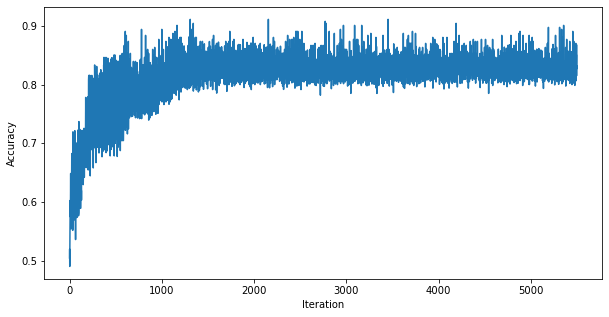

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

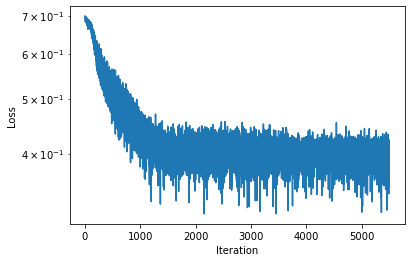

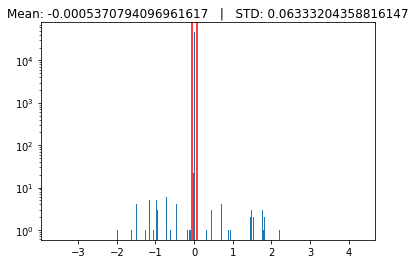

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 5.888888888888889


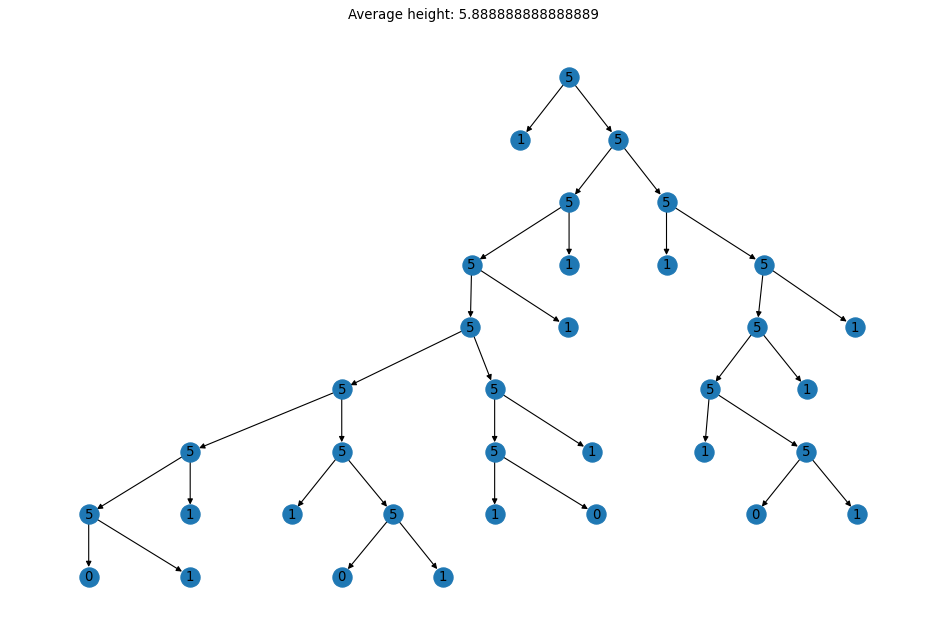

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 18


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/miniconda3/envs/rambo/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

============== Pattern 1 ==============
============== Pattern 2 ==============


/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
Average comprehensibility: 53.0


In [23]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

Accuracy: 0.8136302828788757


In [24]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

Sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1.0: 0.9723756906077348
layer 2.0: 0.9723756906077348
layer 3.0: 0.9723756906077348
layer 4.0: 0.9723756906077348
layer 5.0: 0.9723756906077348
layer 6.0: 0.9723756906077349


## Prune the weights

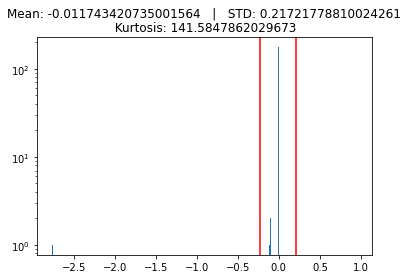

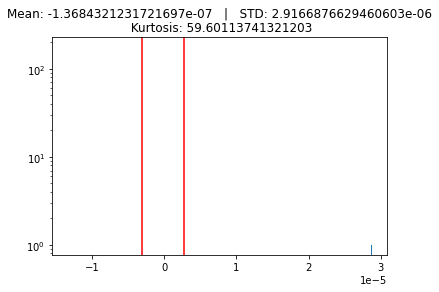

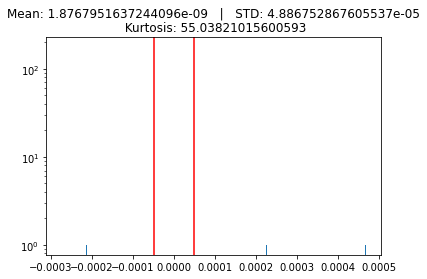

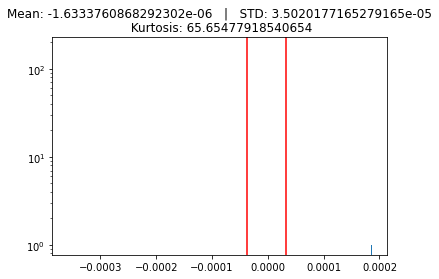

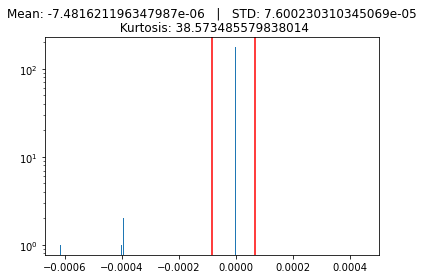

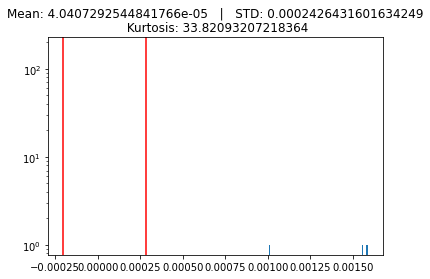

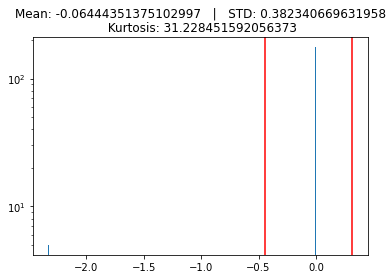

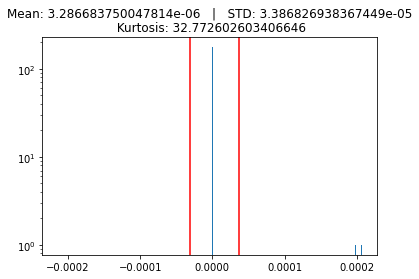

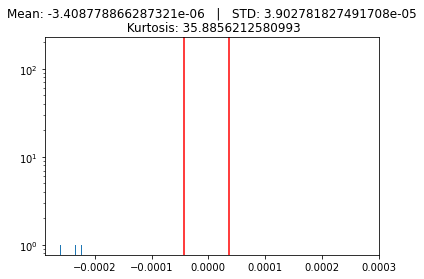

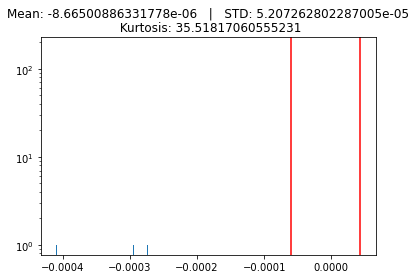

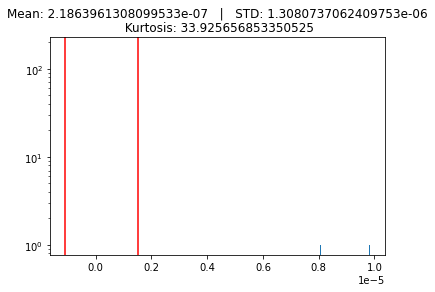

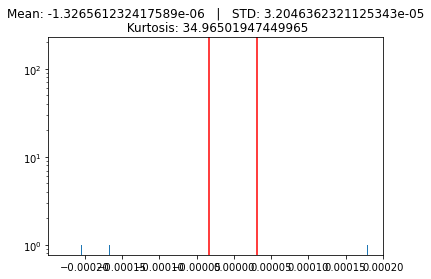

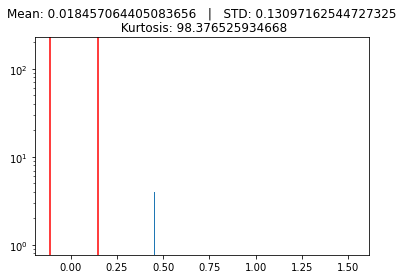

In [25]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [26]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


NameError: name 'tree_copy' is not defined

In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()